# Anomaly Detection per frodi bancarie - Progetto di Data Mining
#### Studentessa Gaia Assunta Bertolino - Mat. 242590 
Corso di laurea magistrale in ingegneria informatica - A.A. 2022/2023

## Introduzione - Goal dell'homework

Il seguente progetto intende trattare un dataset contente una serie di acquisti effettuati con carta di credito. L'obiettivo è individuare le transazioni presumibilmente fraudolente, applicando delle tecniche di anomaly detection e presupponendo una presenza massiccia di transazioni leggittime e una porzione ristretta di anomale.

Il dataset è stato individuato sulla piattaforma Kaggle che rende fruibili in maniera gratuita insiemi di dati di molteplici tipologie e natura.

_Fonte:_ https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTrain.csv

## Indice
1. Definizioni preliminari
2. Pre-processing
- 2.1 Informazioni del dataset
- 2.2 Analisi degli attributi
- 2.3 operazioni di manipolazione
3. Analisi
- 3.1 Valutazioni sugli attributi
- 3.2 Esistenza di correlazione
- 3.3 Operazioni sul dataset
- 3.4 Applicazione del Machine Learning per l'anomaly detection
- - 3.4.1 Decision Tree
- - 3.4.2 Random Forest
- - 3.4.3 Isolation Forrest
- - 3.4.4 Local Outlier Factor
- - 3.4.5 DBSCAN
- - 3.4.6 K Nearest Neighbors Classifier
- 3.5 Rappresentazione grafica degli score
- 3.6 Scelta del modello e tuning
- - 3.6.1 Tuning su accuracy score
- - 3.6.2 Tuning su recall score
- - 3.6.3 Tuning su f1 score 
- 3.7 Applicazione sul test set
4.  Conclusioni

## 1. Definizioni preliminari
Ai fini del progetto, sono utilizzati gli strumenti messi a disposizione dalle librerie qui di seguito importate:
- matplotlib per le rappresentazioni sottoforma di grafico
- sklearn per realizzare i modelli, calcolare le metriche di valutazione, compiere operazioni di splitting e pre processing sul dataset e ottimizzare i parametri dei modelli 
- pandas per la gestione dei dataset sottoforma di dataframe
- seaborn per potenziare gli strumenti visivi forniti da matplotlib

Segue, inoltre, la definizione di due funzioni utili alla rappresentazione delle metriche.

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, tree
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# Funzione che genera una heatmap ovvero una rappresentazione matriciale che esprime una proprietà attarverso l'uso dei colori
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) 

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) 
            val_position = min(max(val_position, 0), 1)
            ind = int(val_position * (n_colors - 1)) 
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 
            val_position = min(max(val_position, 0), 1) 
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) 
    ax = plt.subplot(plot_grid[:,:-1]) 

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order', 'xlabel', 'ylabel'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_ylabel(kwargs.get('ylabel', ''))

    
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) 

        col_x = [0]*len(palette) 
        bar_y=np.linspace(color_min, color_max, n_colors) 

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), 
            left=col_x, 
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) 
        ax.grid(False) 
        ax.set_facecolor('white') 
        ax.set_xticks([]) 
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3))
        ax.yaxis.tick_right()

# Funzione che genera una rappresentazione della correlazione fra una serie di attributi
def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )



---
## 2. Pre-processing
L'attività di pre-processing consiste nell'analizzare e successivamente elaborare i dati grezzi del dataset al fine di renderli adatti alle successive operazioni di estrazione di pattern rilevanti.

#### 2.1 Informazioni del dataset 
L'insieme di dati individuato è fornito sulla piattaforma Kaggle già ripartito in due file, rispettivamente assegnati alla fase di training (ovvero di allenamento del modello) e di testing (di applicazione e valutazione a posteriori del modello)

Il _dataset di training_ risulta essere così composto:

In [3]:
dfTrain = pd.read_csv('data/fraudTrain.csv')
dfTrain.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
# Numero di records del training set
recordTrain = dfTrain.shape[0]
print("Numero di records: " + str(recordTrain))

Numero di records: 1296675


Il _dataset di testing risulta essere così composto:

In [5]:
dfTest = pd.read_csv('data/fraudTest.csv')
dfTest.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [6]:
# Numero di records del testing set
recordTest = dfTest.shape[0]
print("Numero di records: " + str(recordTest))


Numero di records: 555719


In [7]:
# Ripartizione dei records fra testing e training set
totale = recordTrain + recordTest
print("Numero totale di records: " + str(totale))
print("----")
print("Percentuale di ripartizione del dataset")
print("Training set: " + str(round(recordTrain/totale*100,2)) + "%")
print("Test set: " + str(round(recordTest/totale*100,2)) + "%")

Numero totale di records: 1852394
----
Percentuale di ripartizione del dataset
Training set: 70.0%
Test set: 30.0%


---
#### 2.2 Analisi degli attributi
Segue un'analisi del significato di ciascun attributo e di ricerca della presenza di valori mancanti all'interno delle colonne.
1. Significato


* index - Identificatore unico per ciascuna riga
* trans_date_trans_time - Data e ora (DateTime) della transazione
* cc_num - Numero di carta di credito del cliente
* merchant - Nome del venditore
* category - Categoria del venditore
* amt - Ammontare della transazione
* first - Nome del proprietario della carta di credito
* last - Cognome del proprietario della carta di credito
* gender - Genere del proprietario della carta di credito
* street - Indirizzo del proprietario della carta di credito
* city - Città del proprietario della carta di credito
* state - Stato del proprietario della carta di credito
* zip - Zip del proprietario della carta di credito
* lat - Latitudine del proprietario della carta di credito
* long - Longitudine del proprietario della carta di credito
* city_pop - Popolazione della città del proprietario della carta di credito
* job - Lavoro del proprietario della carta di credito
* dob - Data di nascita del proprietario della carta di credito
* trans_num - Numero di transazione
* unix_time - Tempo UNIX della transazione
* merch_lat - Latitudine del venditore
* merch_long - Longitudine del venditore
* is_fraud - Flag di frode 

L'attributo is_fraud rappresenta la classe target ovvero la classe che si vuole predire. Può contenere solo valori quali 0 e 1 i quali rispettivamente indicano la non riconducibilità e la riconducibilità ad una frode.

2. Percentuali di valori mancanti per ogni feature 

In [8]:
dfTrain = dfTrain.drop(columns=["Unnamed: 0"])
print("Train set: ")
df = pd.DataFrame(dfTrain.isnull().sum()/dfTrain.shape[0]).T
df


Train set: 


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Funzione che stampa eventuali features con percentuale di valori NULL maggiore del valore specificato
row = df.iloc[0]
length = row.size
for i in range(length):
    if row[i] > 0.01:
        print("Feature con percentuale di valori nulli maggiore di 0.01:")
        print(df.columns[i])

In [10]:
dfTest = dfTest.drop(columns=["Unnamed: 0"])
print("Test set: ")
df = pd.DataFrame(dfTest.isnull().sum()/dfTest.shape[0]).T
df

Test set: 


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Funzione che stampa eventuali features con percentuale di valori NULL maggiore del valore specificato
row = df.iloc[0]
length = row.size
for i in range(length):
    if row[i] > 0.01:
        print("Feature con percentuale di valori nulli maggiore di 0.01:")
        print(df.columns[i])

Si evince che le feature hanno sicuramente meno dello 0.01% di valori nulli.

3. Valori numerici degli attributi

In [12]:
print("Train set: ")
dfTrain.select_dtypes(include=np.number)

Train set: 


,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,2703186189652095,4.97,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0
1,630423337322,107.23,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0
2,38859492057661,220.11,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0
3,3534093764340240,45.00,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0
4,375534208663984,41.96,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...
1296670,30263540414123,15.56,84735,37.7175,-112.4777,258,1371816728,36.841266,-111.690765,0
1296671,6011149206456997,51.70,21790,39.2667,-77.5101,100,1371816739,38.906881,-78.246528,0
1296672,3514865930894695,105.93,88325,32.9396,-105.8189,899,1371816752,33.619513,-105.130529,0
1296673,2720012583106919,74.90,57756,43.3526,-102.5411,1126,1371816816,42.788940,-103.241160,0


In [13]:
print("Test set: ")
dfTest.select_dtypes(include=np.number)

Test set: 


,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,2291163933867244,2.86,29209,33.9659,-80.9355,333497,1371816865,33.986391,-81.200714,0
1,3573030041201292,29.84,84002,40.3207,-110.4360,302,1371816873,39.450498,-109.960431,0
2,3598215285024754,41.28,11710,40.6729,-73.5365,34496,1371816893,40.495810,-74.196111,0
3,3591919803438423,60.05,32780,28.5697,-80.8191,54767,1371816915,28.812398,-80.883061,0
4,3526826139003047,3.19,49632,44.2529,-85.0170,1126,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...
555714,30560609640617,43.77,63453,40.4931,-91.8912,519,1388534347,39.946837,-91.333331,0
555715,3556613125071656,111.84,77566,29.0393,-95.4401,28739,1388534349,29.661049,-96.186633,0
555716,6011724471098086,86.88,99323,46.1966,-118.9017,3684,1388534355,46.658340,-119.715054,0
555717,4079773899158,7.99,83643,44.6255,-116.4493,129,1388534364,44.470525,-117.080888,0


---
#### 2.3 Operazioni di manipolazione
Dopo una prima fase osservativa del dataset, segue ora una fase di intervento sulle colonne contenute.
Viene dunque inserita una colonna riportante uu attributo Age ottenuto estrapolando l'informazione relativa all'età dalla colonna "dob" ovvero Date Of Birth. Altre due colonne "date" e "time" che contengono rispettivamente l'ora e il giorno della transazione sono aggiunte estrapolandole dall'attributo "trans_date_trans_time" per facilitare l'interazione con le informazioni contenute.

In [14]:
def age(born):
    born = datetime.strptime(born, "%Y-%m-%d").date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))

  
dfTrain['age'] = dfTrain['dob'].apply(age)
dfTrain['trans_date_trans_time'] = pd.to_datetime(dfTrain['trans_date_trans_time'])
dfTrain['date'] = dfTrain['trans_date_trans_time'].dt.strftime("%Y-%m-%d")
dfTrain['time'] = dfTrain['trans_date_trans_time'].dt.strftime("%H:%M:%S")


Da un ragionamento complessivo, per alleggerire l'analisi del dataset si procede ad eliminare quelle colonne che potenzialmente sembrano essere irrilevanti ai fini dell'analisi:

* index - Identificatore unico per ciascuna riga
* trans_date_trans_time - Data e ora (DateTime) della transazione
* merchant - Nome del venditore
* first - Nome del proprietario della carta di credito
* zip - Zip del proprietario della carta di credito     
* dob - Data di nascita del proprietario della carta di credito
* trans_num - Numero di transazione
* unix_time - Tempo UNIX della transazione
* street - Indirizzo del proprietario della carta di credito
* cc_num - Numero di carta di credito del cliente
* lat - Latitudine del proprietario della carta di credito
* long - Longitudine del proprietario della carta di credito

Invece saranno tenuti in considerazione i seguenti attributi:
* is_fraud - Flag di frode (0=No, 1=Yes) e cioè la classe che si vuole predire
* category - Categoria del venditore
* age - Età del proprietario della carta di credito
* city - Città del proprietario della carta di credito
* amt - Ammontare della transazione
* date - Giorno della transazione
* time - Orario della transazione
* city_pop - Popolazione della città del proprietario della carta di credito
* gender - Genere del proprietario della carta di credito
* state - Stato del proprietario della carta di credito
* merch_lat - Latitudine del venditore
* merch_long - Longitudine del venditore
* job - Lavoro del proprietario della carta di credito
* last - Cognome del proprietario della carta di credito




In [15]:
# Colonne prima del pruning
dfTrain.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'age', 'date', 'time'],
      dtype='object')

In [16]:
dfTrain = dfTrain.drop(['trans_date_trans_time', 'merchant',
              'first', 'zip', 'dob', 'unix_time',
              'street', 'cc_num', 'lat', 'long'], axis=1)


In [17]:
# Colonne dopo il pruning
dfTrain.columns

Index(['category', 'amt', 'last', 'gender', 'city', 'state', 'city_pop', 'job',
       'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'age', 'date',
       'time'],
      dtype='object')

---
## 3. Analisi
Segue la fase di analisi del dataset al fine di individuare pattern interessanti all'obiettivo del progetto.
#### 3.1 Valutazioni sugli attributi
Lo scopo è di individuare quelle variabili che sono importanti per predire se una transazione è fraudolenta o meno. A tal proposito, sono formulate delle ipotesi in merito a quelli che possono essere attributi il cui valore può essere strettamente legato al valore della classe target. Si parla in questi casi di esistenza (o assenza) di correlazione, la quale indica la tendenza che hanno due variabili a variare insieme e cioè a covariare.

#### Prima valutazione:
Il genere del proprietario della carta influenza l'azione fraudolenta in quanto le donne sono molto più soggette ad essere derubate delle proprie carte di credito

In [18]:
df_sex = dfTrain.groupby(['gender', 'is_fraud'])[['trans_num']].count()
df_sex = df_sex.rename({'trans_num': 'count'}, axis=1)
df_sex['prob'] = df_sex['count'] / dfTrain.groupby('gender').count()['is_fraud']
df_sex.sort_values(by=['prob'], ascending=False)

count      prob
gender is_fraud                  
F      0         706128  0.994738
M      0         583041  0.993574
       1           3771  0.006426
F      1           3735  0.005262

Si evince come il numero di frodi si verifichi all'incirca nella stessa percentuale fra uomini e donne

#### Seconda valutazione:
L'età del proprietario della carta influenza l'azione fraudolenta in quanto gli anziani sono molto più soggetti ad essere derubati delle proprie carte di credito

In [19]:
df_age = dfTrain.groupby(['age', 'is_fraud'])[['trans_num']].count()
df_age = df_age.rename({'trans_num': 'count'}, axis=1)
df_age['prob'] = df_age['count'] / dfTrain.groupby('age').count()['is_fraud']
df_age.sort_values(by=['prob'], ascending=False)

,,count,prob
age,is_fraud,,
21,0,994,1.000000
38,0,40275,0.997350
45,0,20869,0.996990
19,0,4953,0.996780
35,0,38925,0.996314
...,...,...,...
50,1,117,0.003701
35,1,144,0.003686
19,1,16,0.003220


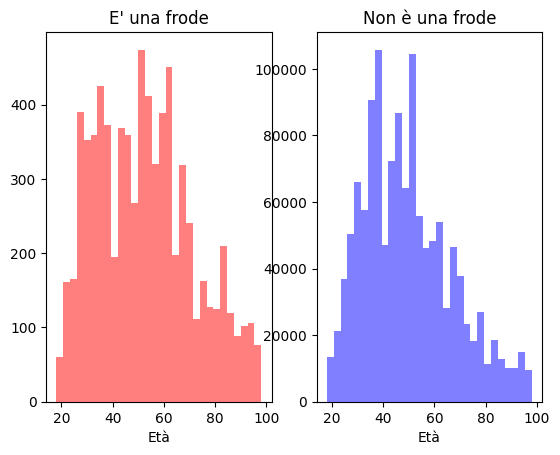

In [20]:
is_fraud = dfTrain[dfTrain["is_fraud"] == 1]
is_not_fraud = dfTrain[dfTrain["is_fraud"] == 0]
fig, axes = plt.subplots(1,2)
axes[0].hist(is_fraud["age"].dropna(), alpha=0.5, color='red', bins=30)
axes[1].hist(is_not_fraud["age"].dropna() ,alpha=0.5,color='blue',bins=30)
axes[0].set_title('E\' una frode')
axes[1].set_title('Non è una frode')
axes[0].set_xlabel('Età')
axes[1].set_xlabel('Età')
plt.show()

Rispetto all'assunzione fatta, un grande numero di frodi presenti nel dataset si verifica fra i più giovani. Tuttavia, i valori riportati sono in termini assoluti e non percentuali.

Text(0.5, 1.0, 'Probabilità che sia una frode')

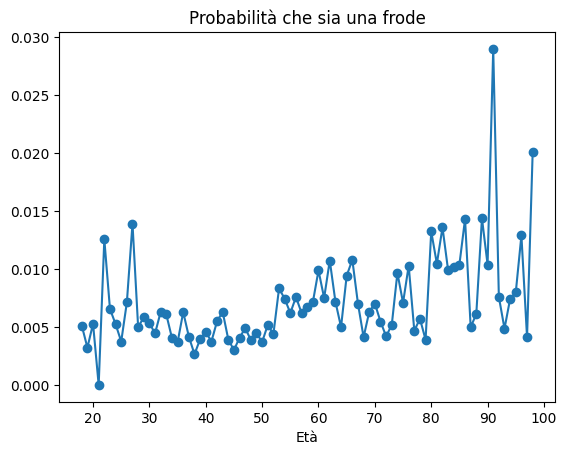

In [21]:
df_sib = pd.pivot_table(dfTrain, index='age', values="is_fraud")

fig, ax = plt.subplots(1,1)

ax.plot(df_sib, marker='o')

ax.set_xlabel("Età")
ax.set_title("Probabilità che sia una frode")

Rapportando il numero di frodi alle transazioni effettuate, la probabilità che una transazione sia una frode è molto più alta negli anziani e nei ventenni. 

Sovrapposizione fra età e genere:

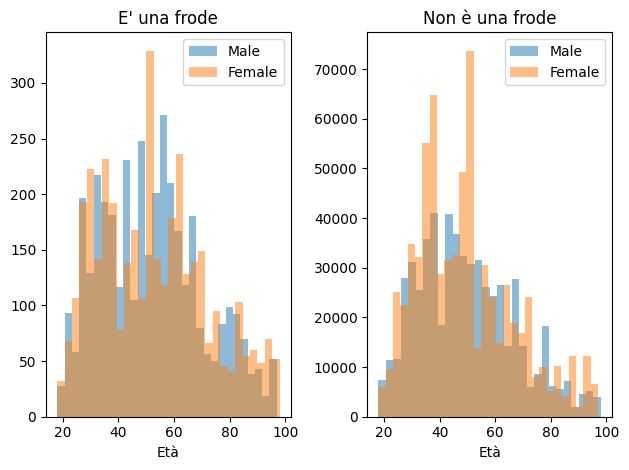

In [22]:
is_fraud = dfTrain[dfTrain["is_fraud"] == 1]
is_not_fraud = dfTrain[dfTrain["is_fraud"] == 0]
fig, axes = plt.subplots(1,2)
axes[0].hist(is_fraud.loc[is_fraud["gender"] == "M"]["age"].dropna(), label='Male', alpha=0.5, bins=30)
axes[0].hist(is_fraud.loc[is_fraud["gender"] == "F"]["age"].dropna(), label='Female', alpha=0.5, bins=30)

axes[1].hist(is_not_fraud.loc[is_not_fraud["gender"] == "M"]["age"].dropna(), label='Male', alpha=0.5, bins=30)
axes[1].hist(is_not_fraud.loc[is_not_fraud["gender"] == "F"]["age"].dropna(), label='Female', alpha=0.5, bins=30)

axes[0].set_title('E\' una frode')
axes[1].set_title('Non è una frode')

axes[0].set_xlabel('Età')
axes[1].set_xlabel('Età')

axes[0].legend()
axes[1].legend()
fig.tight_layout() 
plt.show()

Ciò che ne consegue è che tra i 40 e i 60 anni c'è un numero maggiore di frodi compiute attraverso carte di credito che appartengono a donne.

#### Terza valutazione:
Il lavoro del proprietario della carta influenza l'azione fraudolenta in quanto chi fa lavori che richiedono una maggiore formazione è molto meno soggetto ad essere derubato delle proprie carte di credito

In [23]:
df_job = dfTrain.groupby(['job', 'is_fraud'])[['trans_num']].count()
df_job = df_job.rename({'trans_num': 'count'}, axis=1)
df_job['prob'] = df_job['count'] / dfTrain.groupby('job').count()['is_fraud']
df_job.sort_values(by=['prob'], ascending=False)

,,count,prob
job,is_fraud,,
"Scientist, clinical (histocompatibility and immunogenetics)",0,1054,1.000000
Physiological scientist,0,1540,1.000000
Television camera operator,0,518,1.000000
Broadcast journalist,1,9,1.000000
Psychiatric nurse,0,1553,1.000000
...,...,...,...
Statistician,1,3,0.001154
Health physicist,1,3,0.000989
Contractor,1,2,0.000662


Sono di seguito rappresentati i primi dieci lavori in ordine di presenza nei casi

C:\Users\gaiab\AppData\Local\Temp\ipykernel_23712\2999310446.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(is_fraud['job'], rotation=90, ha='right')
C:\Users\gaiab\AppData\Local\Temp\ipykernel_23712\2999310446.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(is_not_fraud['job'], rotation=90, ha='right')


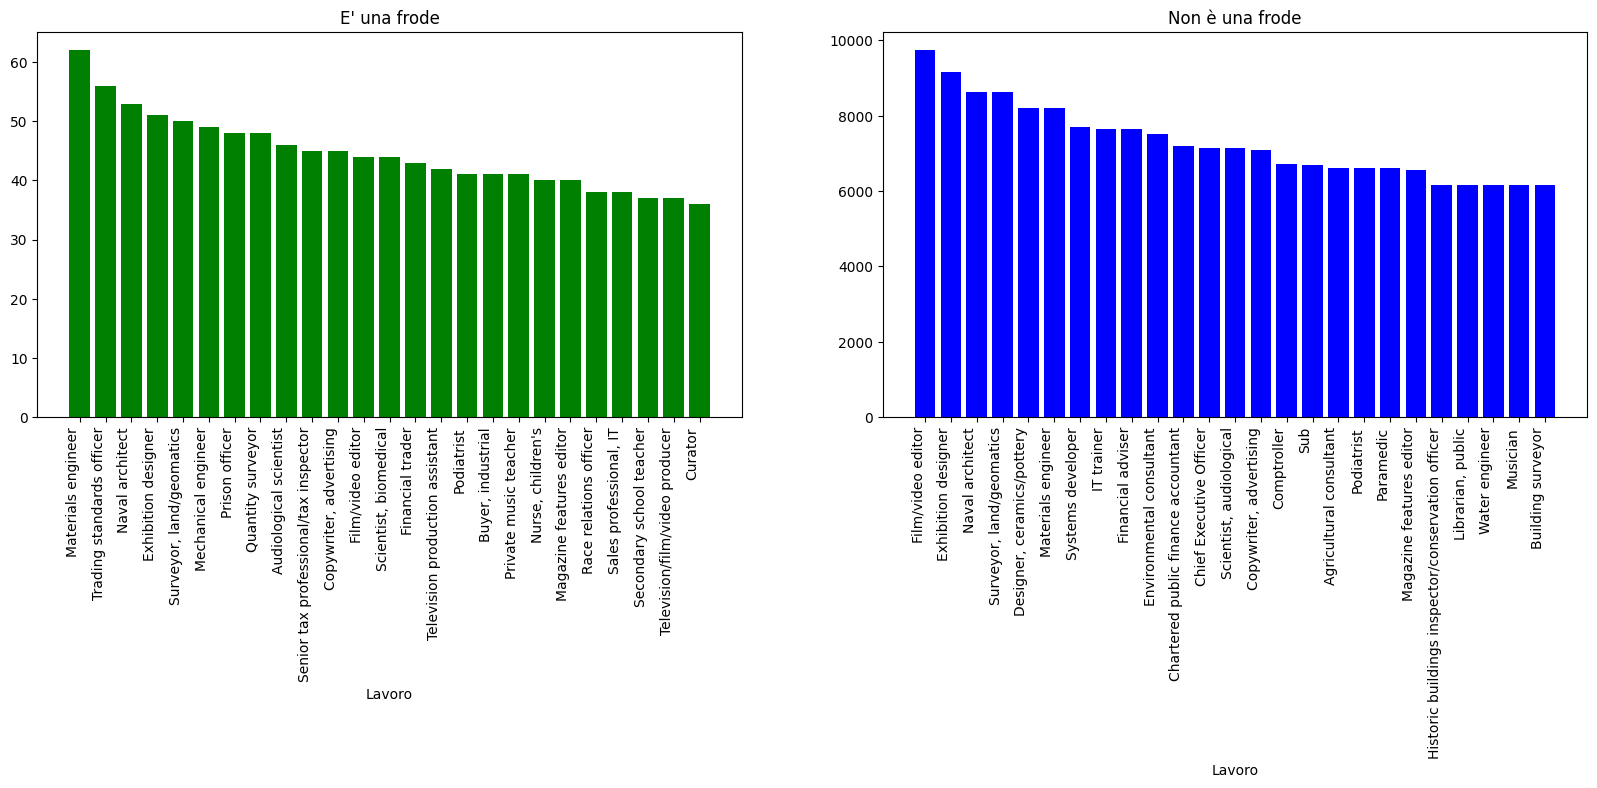

In [24]:
is_fraud = dfTrain[dfTrain["is_fraud"] == 1]
is_not_fraud = dfTrain[dfTrain["is_fraud"] == 0]

is_fraud = is_fraud.groupby('job').size().reset_index(name='counts').sort_values(by='counts', ascending=False).iloc[:25]
is_not_fraud = is_not_fraud.groupby('job').size().reset_index(name='counts').sort_values(by='counts', ascending=False).iloc[:25]

fig, axes = plt.subplots(1,2, figsize=(20, 5))
axes[0].bar(is_fraud["job"],is_fraud['counts'], color='green')
axes[0].set_xticklabels(is_fraud['job'], rotation=90, ha='right')
axes[1].bar(is_not_fraud["job"], is_not_fraud['counts'], color='blue')
axes[1].set_xticklabels(is_not_fraud['job'], rotation=90, ha='right')
axes[0].set_title('E\' una frode')
axes[1].set_title('Non è una frode')
axes[0].set_xlabel('Lavoro')
axes[1].set_xlabel('Lavoro')

plt.show()

Non sembra esserci una presenza massiccia di casi legati ad una singola professione in quanto l'andamento del grafico è piuttosto omogeneo.

#### Quarta valutazione:
La città del proprietario della carta influenza l'azione fraudolenta in quanto esistono città in cui si è molto più soggetti ad essere derubati delle proprie carte di credito

In [25]:
df_city = dfTrain.groupby(['city', 'is_fraud'])[['trans_num']].count()
df_city = df_city.rename({'trans_num': 'count'}, axis=1)
df_city['prob'] = df_city['count'] / dfTrain.groupby('city').count()['is_fraud']
df_city.sort_values(by=['count'], ascending=False)

,,count,prob
city,is_fraud,,
Birmingham,0,5606,0.998042
San Antonio,0,5105,0.995127
Utica,0,5080,0.995103
Phoenix,0,5073,0.999606
Meridian,0,5047,0.997431
...,...,...,...
Grandview,1,3,0.000987
Kilgore,1,2,0.001305
Phenix City,1,2,0.000999


Sono di seguito rappresentate le prime dieci città in ordine di presenza nei casi

C:\Users\gaiab\AppData\Local\Temp\ipykernel_23712\729784834.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(is_fraud['city'], rotation=90, ha='right')
C:\Users\gaiab\AppData\Local\Temp\ipykernel_23712\729784834.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(is_not_fraud['city'], rotation=90, ha='right')


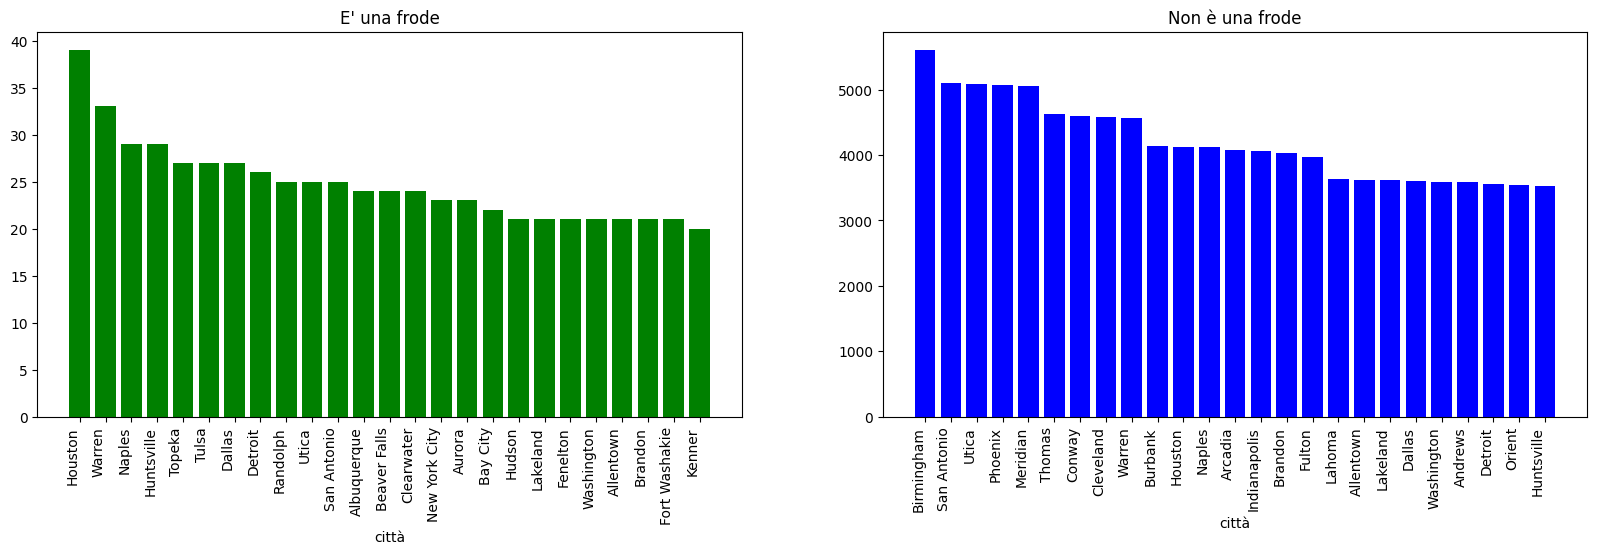

In [100]:
is_fraud = dfTrain[dfTrain["is_fraud"] == 1]
is_not_fraud = dfTrain[dfTrain["is_fraud"] == 0]

is_fraud = is_fraud.groupby('city').size().reset_index(name='counts').sort_values(by='counts', ascending=False).iloc[:25]
is_not_fraud = is_not_fraud.groupby('city').size().reset_index(name='counts').sort_values(by='counts', ascending=False).iloc[:25]

fig, axes = plt.subplots(1,2, figsize=(20, 5))
axes[0].bar(is_fraud["city"],is_fraud['counts'], color='green')
axes[0].set_xticklabels(is_fraud['city'], rotation=90, ha='right')
axes[1].bar(is_not_fraud["city"], is_not_fraud['counts'], color='blue')
axes[1].set_xticklabels(is_not_fraud['city'], rotation=90, ha='right')
axes[0].set_title('E\' una frode')
axes[1].set_title('Non è una frode')
axes[0].set_xlabel('città')
axes[1].set_xlabel('città')

plt.show()

Da un grafico del genere, è possibile soprattutto evincere se la presenza nei casi positivi si riveli anche in quelli negativi, denotando dunque la presenza o meno di un rapporto fra frodi/non frodi non differente dalle altre città.

#### Quinta valutazione:
La popolazione della città del proprietario della carta influenza l'azione fraudolenta in quanto in città più popolose si è molto più soggetti ad essere derubati delle proprie carte di credito

In [27]:
df_pop = dfTrain.groupby(['city_pop', 'is_fraud'])[['trans_num']].count()
df_pop = df_pop.rename({'trans_num': 'count'}, axis=1)
df_pop['prob'] = df_pop['count'] / dfTrain.groupby('city_pop').count()['is_fraud']
df_pop.sort_values(by=['prob'], ascending=False)

,,count,prob
city_pop,is_fraud,,
12866,1,8,1.000000
346,0,2048,1.000000
59705,0,501,1.000000
6713,0,1519,1.000000
6841,0,2564,1.000000
...,...,...,...
5875,1,3,0.000987
19685,1,3,0.000985
6120,1,3,0.000982


Text(0.5, 1.0, 'Probabilità che sia una frode')

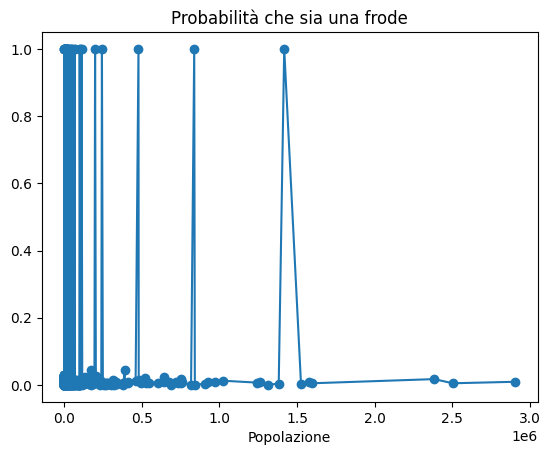

In [88]:
df_sib = pd.pivot_table(dfTrain, index='city_pop', values='is_fraud')

fig, ax = plt.subplots(1,1)

ax.plot(df_sib, marker='o')

ax.set_xlabel("Popolazione")
ax.set_title('Probabilità che sia una frode')

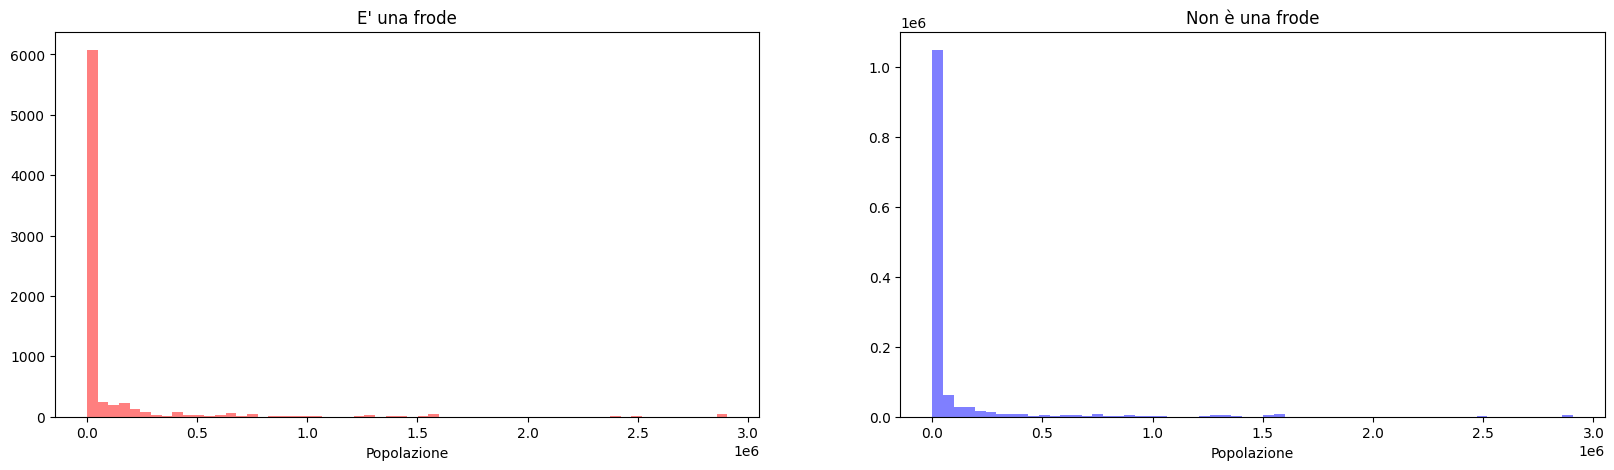

In [106]:
is_fraud = dfTrain[dfTrain["is_fraud"] == 1]
is_not_fraud = dfTrain[dfTrain["is_fraud"] == 0]
fig, axes = plt.subplots(1,2, figsize=(20, 5))
axes[0].hist(is_fraud["city_pop"].dropna(), alpha=0.5, color='red', bins=60)
axes[1].hist(is_not_fraud["city_pop"].dropna() ,alpha=0.5,color='blue',bins=60)
axes[0].set_title('E\' una frode')
axes[1].set_title('Non è una frode')
axes[0].set_xlabel('Popolazione')
axes[1].set_xlabel('Popolazione')
plt.show()

Per popolazioni molto grandi sembra decisamente abbassarsi la probabilità che un caso sia una frode.

#### Sesta assunzione:
L'orario della transazione influenza l'azione fraudolenta in quanto le azioni fraudolente vengono portate avanti ad orari poco affollati

In [30]:
df_time = dfTrain.groupby(['time', 'is_fraud'])[['trans_num']].count()
df_time = df_time.rename({'trans_num': 'count'}, axis=1)
df_time['prob'] = df_time['count'] / dfTrain.groupby('time').count()['is_fraud']
df_time.sort_values(by=['prob'], ascending =False)

,,count,prob
time,is_fraud,,
12:08:41,0,24,1.000000
14:12:53,0,21,1.000000
14:27:17,0,18,1.000000
14:27:16,0,21,1.000000
14:27:15,0,26,1.000000
...,...,...,...
23:41:20,1,1,0.031250
14:37:52,1,1,0.029412
22:13:36,1,1,0.029412


C:\Users\gaiab\AppData\Local\Temp\ipykernel_23712\3262210533.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(is_fraud['time'], rotation=90, ha='right')
C:\Users\gaiab\AppData\Local\Temp\ipykernel_23712\3262210533.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(is_not_fraud['time'], rotation=90, ha='right')


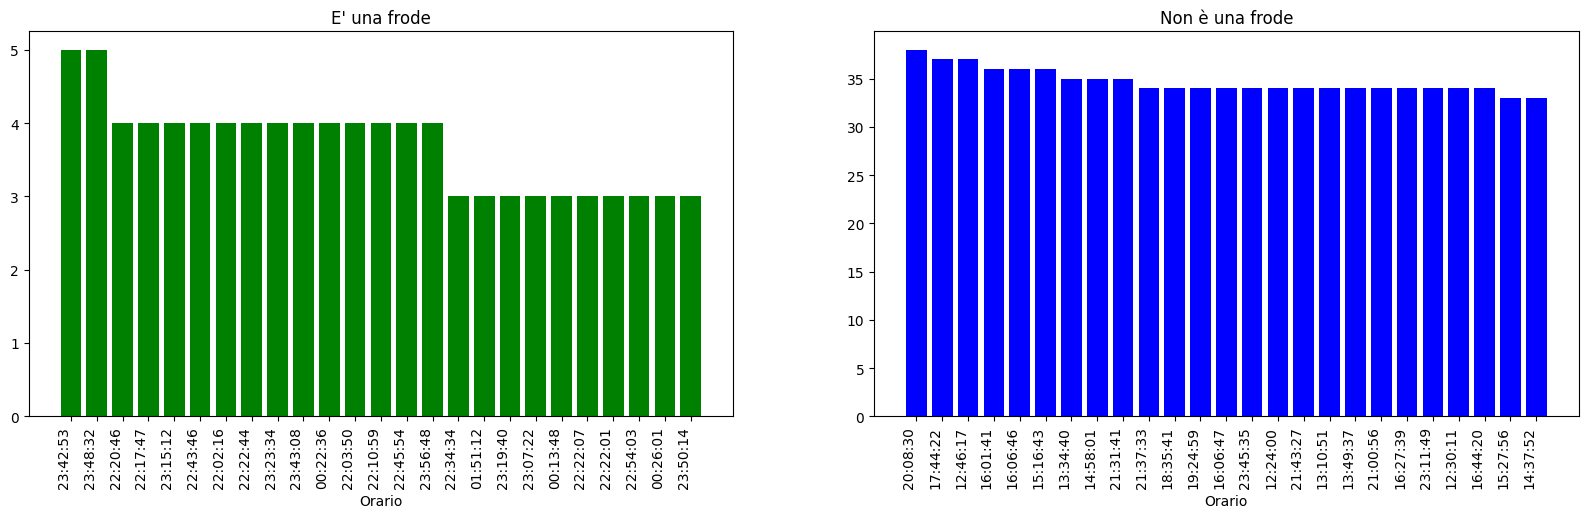

In [31]:
is_fraud = dfTrain[dfTrain["is_fraud"] == 1]
is_not_fraud = dfTrain[dfTrain["is_fraud"] == 0]

is_fraud = is_fraud.groupby('time').size().reset_index(name='counts').sort_values(by='counts', ascending=False).iloc[:25]
is_not_fraud = is_not_fraud.groupby('time').size().reset_index(name='counts').sort_values(by='counts', ascending=False).iloc[:25]

fig, axes = plt.subplots(1,2, figsize=(20, 5))
axes[0].bar(is_fraud["time"],is_fraud['counts'], color='green')
axes[0].set_xticklabels(is_fraud['time'], rotation=90, ha='right')
axes[1].bar(is_not_fraud["time"], is_not_fraud['counts'], color='blue')
axes[1].set_xticklabels(is_not_fraud['time'], rotation=90, ha='right')
axes[0].set_title('E\' una frode')
axes[1].set_title('Non è una frode')
axes[0].set_xlabel('Orario')
axes[1].set_xlabel('Orario')

plt.show()

Nella pole position degli orari con maggiori frodi, rientrano soltanto ore notturne comprese fra le 22 e le 2, probabilmente a causa del fatto che in fasce tarde sia più semplice poter compiere atti illeciti.

#### Settima assunzione:
L'ammontare della transazione influenza l'azione fraudolenta in quanto le azioni fraudolente vengono portate avanti con pagamenti di piccola taglia

In [32]:
df_amount = dfTrain.groupby(['amt', 'is_fraud'])[['trans_num']].count()
df_amount = df_amount.rename({'trans_num': 'count'}, axis=1)
df_amount['prob'] = df_amount['count'] / dfTrain.groupby('amt').count()['is_fraud']
df_amount.sort_values(by=['prob'])

,,count,prob
amt,is_fraud,,
1.06,1,1,0.002123
1.91,1,1,0.002183
2.13,1,1,0.002304
2.25,1,1,0.002315
2.48,1,1,0.002342
...,...,...,...
188.19,0,4,1.000000
188.20,0,10,1.000000
188.21,0,13,1.000000


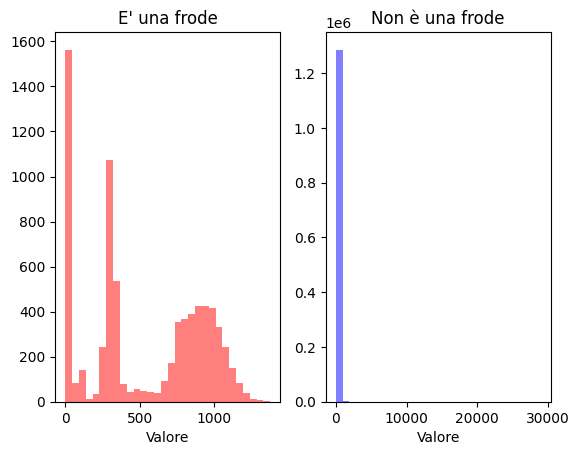

In [33]:
is_fraud = dfTrain[dfTrain["is_fraud"] == 1]
is_not_fraud = dfTrain[dfTrain["is_fraud"] == 0]
fig, axes = plt.subplots(1,2)
axes[0].hist(is_fraud["amt"].dropna(), alpha=0.5, color='red', bins=30)
axes[1].hist(is_not_fraud["amt"].dropna() ,alpha=0.5,color='blue',bins=30)
axes[0].set_title('E\' una frode')
axes[1].set_title('Non è una frode')
axes[0].set_xlabel('Valore')
axes[1].set_xlabel('Valore')
plt.show()

Seppur la maggior parte delle frodi avvenga per piccoli pagamenti, intorno ai mille euro nella distribuzione vi è sicuramente un massimo locale non indifferente mentre successivamente la funzione tende ad annullarsi per cui diventano rari (quasi zero) i casi di frode per alte cifre.

--- 
#### 3.2 Esistenza di correlazione
Per valutare l'esistenza di correlazione, si è ricorso all'uso della funzione corr e ad una rappresentazione grafica sottoforma di heatmap dei valori di correlazione lineare reciproca. Per poter fare ciò è stato necessario codificare attraverso l'one-hot encoding in valori numerici le variabili categoriche presenti

In [34]:
# One-hot encoding

label_encoder = preprocessing.LabelEncoder()
dfLabel = dfTrain.copy()

columnsToLabel = ['category', 'city', 'date', 'time', 'gender', 'state', 'job', 'last']

for col in columnsToLabel:
    dfLabel[col] = label_encoder.fit_transform(dfLabel[col].astype(str))


In [35]:
# Dataframe codificato
dfLabel

,category,amt,last,gender,city,state,city_pop,job,trans_num,merch_lat,merch_long,is_fraud,age,date,time
0,8,4.97,18,0,526,27,3495,370,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,35,0,18
1,4,107.23,157,0,612,47,149,428,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,45,0,44
2,0,220.11,381,1,468,13,4154,307,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,61,0,51
3,2,45.00,463,1,84,26,1939,328,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,56,0,76
4,9,41.96,149,1,216,45,99,116,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,37,0,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,0,15.56,332,1,330,44,258,215,440b587732da4dc1a6395aba5fb41669,36.841266,-111.690765,0,61,536,43928
1296671,1,51.70,463,1,813,20,100,360,278000d2e0d2277d1de2f890067dcc0a,38.906881,-78.246528,0,43,536,43939
1296672,1,105.93,67,1,346,32,899,308,483f52fe67fabef353d552c1e662974c,33.619513,-105.130529,0,56,536,43952
1296673,1,74.90,304,1,471,41,1126,485,d667cdcbadaaed3da3f4020e83591c83,42.788940,-103.241160,0,43,536,44016


In [36]:
# Calcolo della correlazione
corr = dfLabel.corr(numeric_only = True)
corr

,category,amt,last,gender,city,state,city_pop,job,merch_lat,merch_long,is_fraud,age,date,time
category,1.000000,0.030867,-0.004319,-0.028259,0.000784,0.000211,0.009386,0.003490,-0.008519,-0.000736,0.020205,-0.003968,-0.000120,0.158254
amt,0.030867,1.000000,-0.004708,0.001034,-0.000565,0.001718,0.005818,-0.000628,-0.001873,-0.000151,0.219404,-0.009816,-0.000244,-0.022774
last,-0.004319,-0.004708,1.000000,0.043740,0.017553,-0.048161,-0.012039,-0.024596,-0.034548,-0.025557,-0.000096,0.020093,0.000092,0.000812
gender,-0.028259,0.001034,0.043740,1.000000,0.016039,-0.031794,-0.028649,-0.079908,0.042645,0.050350,0.007642,0.006436,-0.000887,-0.037855
city,0.000784,-0.000565,0.017553,0.016039,1.000000,-0.043064,0.034923,0.020446,-0.031828,-0.066718,-0.002092,-0.018172,-0.000479,0.006961
state,0.000211,0.001718,-0.048161,-0.031794,-0.043064,1.000000,-0.012197,0.042915,0.211844,0.132346,0.001730,-0.051871,0.001058,0.006862
city_pop,0.009386,0.005818,-0.012039,-0.028649,0.034923,-0.012197,1.000000,-0.054945,-0.154781,-0.052687,0.002136,-0.093364,-0.001754,0.020334
job,0.003490,-0.000628,-0.024596,-0.079908,0.020446,0.042915,-0.054945,1.000000,-0.027412,-0.002727,-0.000093,-0.026289,0.000009,0.011825
merch_lat,-0.008519,-0.001873,-0.034548,0.042645,-0.031828,0.211844,-0.154781,-0.027412,1.000000,-0.015431,0.001741,0.047795,0.000583,-0.011378
merch_long,-0.000736,-0.000151,-0.025557,0.050350,-0.066718,0.132346,-0.052687,-0.002727,-0.015431,1.000000,0.001721,-0.029684,-0.000629,-0.002357


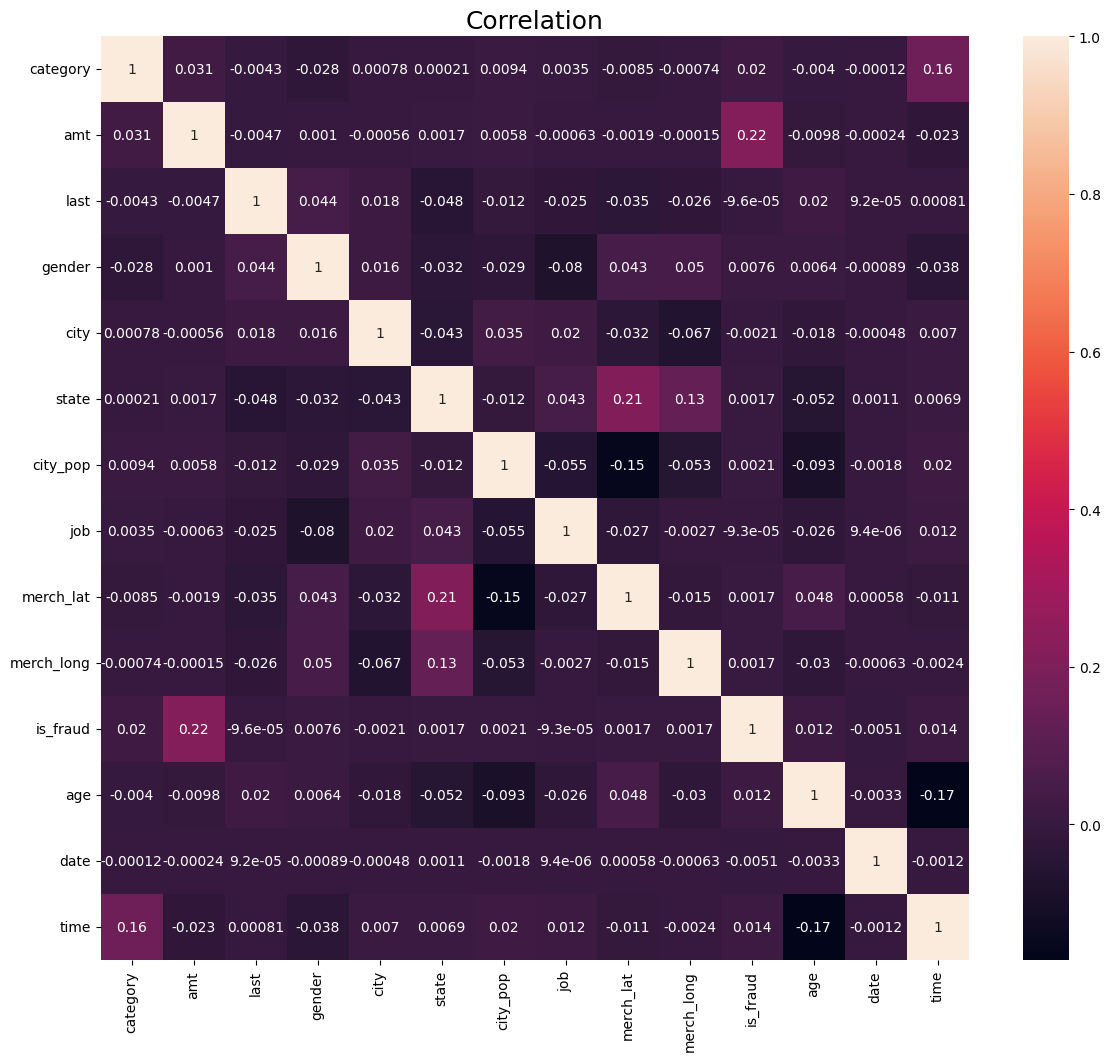

In [37]:
# Rappresentazione della matrice di correlazione tramite heat-map
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True)
plt.title('Correlation', fontsize=18);
     

Dalla heatmap si evince come esista una correlazione rilevante fra l'ammontare della transazione e il valore della variabile target. Tuttavia è importante sottolineare come l'applicazione di tale funzione è in grado di identificare solamente l'esistenza di correlazione lineare reciproca fra gli attributi. Per individuare altre tipologie di correlazione è necessario ricorrere all'uso di funzioni ad hoc.

C:\Users\gaiab\AppData\Local\Temp\ipykernel_23712\1268471045.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrplot(dfLabel.corr(), size_scale=300);


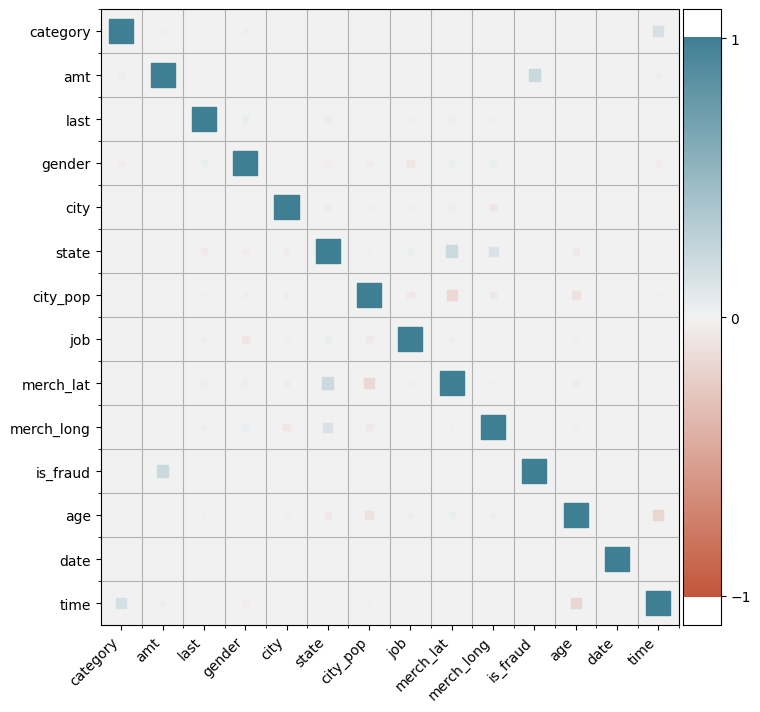

In [38]:
# Rappresentazione alternativa della correlazione
plt.figure(figsize=(8, 8))
corrplot(dfLabel.corr(), size_scale=300);

In particolare, per approfondire la correlazione con la sola variabile target usiamo un grafico specifico:

C:\Users\gaiab\AppData\Local\Temp\ipykernel_23712\2605933453.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrFraud = dfLabel.corrwith(dfLabel["is_fraud"])


<AxesSubplot: >

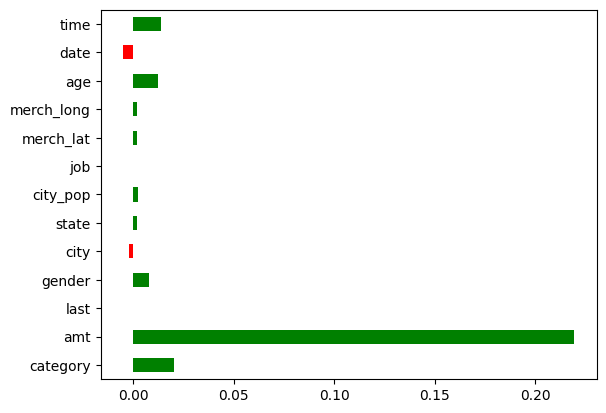

In [39]:
# Correlazione con la sola variabile target
corrFraud = dfLabel.corrwith(dfLabel["is_fraud"])
corrFraud = corrFraud.drop('is_fraud')
corrFraud.plot(kind='barh', color = (corrFraud > 0).map({True: 'g', False: 'r'}))

Da tale grafico si evince la forte rilevanza già individuata dell'attributo "amt". Tuttavia, altri attributi sono legati a dei valori di correlazione non nulli seppur molto piccoli. Irrilevanti alla correlazione lineare sembrano essere invece la variabile "job" e la variabile "last" che identifica il cognome e che sarebbe potuta essere rilevante nel caso di bias.

---
### 3.3 Operazioni sul dataset

In questa sezione seguono le operazioni atte a dividere il training set in due parti: training set effettivo e validation set. Tale suddivisione viene utilizzata per avere un set usato per l'effettivo allenamento del modello e un set di validazione dei risultati per validare, grazie a delle metriche apposite, il funzionamento del modello. Infine, esso sarà applicato al test set per valutare come un modello allenato in maniera supervisionata (ovvero in presenza di etichette) agisca in fase predittiva.

In [40]:
# Definizione del dataset utilizzato nelle operazioni di machine learning
dfMachine = dfLabel.copy()
dfMachine = dfMachine.drop(columns=['trans_num'])
dfMachine

,category,amt,last,gender,city,state,city_pop,job,merch_lat,merch_long,is_fraud,age,date,time
0,8,4.97,18,0,526,27,3495,370,36.011293,-82.048315,0,35,0,18
1,4,107.23,157,0,612,47,149,428,49.159047,-118.186462,0,45,0,44
2,0,220.11,381,1,468,13,4154,307,43.150704,-112.154481,0,61,0,51
3,2,45.00,463,1,84,26,1939,328,47.034331,-112.561071,0,56,0,76
4,9,41.96,149,1,216,45,99,116,38.674999,-78.632459,0,37,0,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,0,15.56,332,1,330,44,258,215,36.841266,-111.690765,0,61,536,43928
1296671,1,51.70,463,1,813,20,100,360,38.906881,-78.246528,0,43,536,43939
1296672,1,105.93,67,1,346,32,899,308,33.619513,-105.130529,0,56,536,43952
1296673,1,74.90,304,1,471,41,1126,485,42.788940,-103.241160,0,43,536,44016


In [41]:
# Suddivisione delle colonne
X = dfMachine.drop('is_fraud', axis=1)
y = dfMachine['is_fraud']

# Split in validation e train set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.33, random_state=42)

# Stampa  a video del numero di righe
print("train set shape:")
print(X_train.shape)

print("validation set shape:")
print(X_validation.shape)

train set shape:
(868772, 13)
validation set shape:
(427903, 13)


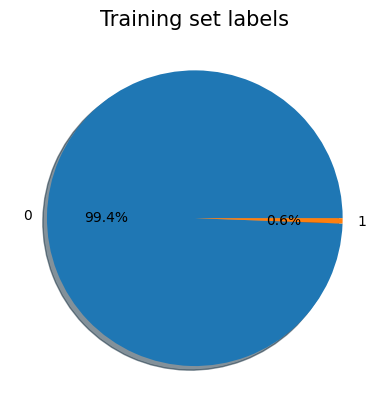

In [42]:
# Ripartizione delle classi target
data = []
label = ["0", "1"]

for classNum in range(len(label)):
  data.append(np.sum(np.array(y_train) == classNum)) 

plt.title("Training set labels", fontsize=15)
plt.pie(data, labels=label, shadow=True, autopct='%1.1f%%')
plt.show()

---
### 3.4 Applicazione del Machine Learning per l'anomaly dection
Il rilevamento delle anomalie è il processo di identificazione dei punti dati che non rientrano nel comportamento normale. Osservando i set di dati e i punti che non si adattano, le parti interessate aziendali e i team di dati possono identificare modelli o punti che potrebbero rappresentare minacce. Le aziende utilizzano il data mining anche per attività di rilevamento di frodi e intrusioni di rete.

Nel caso del rilevamento di frodi presso una società di carte di credito, gli algoritmi di rilevamento delle anomalie cercano punti dati insoliti per i titolari delle carte. Supponiamo che l'attività frugale della carta di credito di un titolare di carta abbia registrato diversi acquisti stravaganti in un solo giorno. Molto probabilmente la società emittente della carta di credito lo segnalerà come potenziale frode e agirà per verificarlo. 

Non tutti i dati insoliti sono motivo di preoccupazione. È qui che entra in gioco il rilevamento degli outlier. Secondo il set di dati di addestramento, i valori anomali possono sembrare anomali ma sono punti dati rari , ovvero un set di dati di grandi dimensioni utilizzato da un algoritmo di apprendimento automatico per il rilevamento di anomalie per apprendere il comportamento normale.

#### Tipologie di anomalie
1. Anomalie puntuali
 Si verifica quando un singolo punto dati è estremamente lontano dalla distribuzione. Ad esempio, una persona che tenta di incassare un assegno da un milione di dollari costituirebbe un'anomalia puntuale.
2. Anomalie contestuali
Nelle anomalie dei dati delle serie temporali, i punti dati che risaltano sono quelli che non si adattano al modello testato nel tempo. Ad esempio, se il numero di auto che attraversano un singolo casello in un normale martedì dovesse aumentare da 1.000 a 10.000.
3. Anomalie collettive
Si verifica quando diversi punti dati, o una raccolta, si trovano molto al di fuori degli ambienti di comportamento normale, ma i singoli punti dati non sono anomali. Tutti coloro che ridipingono la propria casa lo stesso giorno sono un'anomalia collettiva perché non è insolito che le persone dipingano la propria casa. Ma è raro che tutti lo facciano lo stesso giorno.
4. Anomalia di aggiornamento
Questa anomalia si verifica quando i dati sono diventati ridondanti o sono stati parzialmente aggiornati. Ad esempio, le torte vendute in una panetteria possono essere classificate sia in base al numero di croste che al fatto che contengano o meno un ripieno di frutta. Si verificherebbe un'anomalia di aggiornamento se nell'elenco delle torte di frutta venisse aggiornata una torta di mele a doppia crosta, ma non l'altra.
5. Anomalia di cancellazione
Quando i dati vengono persi perché sono stati rimossi, si può verificare un'anomalia di cancellazione. Un esempio potrebbe essere se una torta di budino al cioccolato con doppia crosta che viene rimossa dall'inventario, non perché è stata venduta, ma perché è stata eliminata per sbaglio.
6. Anomalia di inserimento
L'anomalia di inserimento riguarda in realtà l'omissione. Quando i dati non possono essere inseriti nel set di dati perché incompleti, si verifica un'anomalia di inserimento dovuta al mancato inserimento dei dati. Ad esempio, quando una torta sperimentale di noci pecan senza crosta non è inclusa nell'inventario. 


#### Rilevazione delle anomalie
Le tecniche di individuazione di outliers sono multiple:
Si parla innanzitutto di approccio model-based o model-free rispettivamente se si basano rispettivamente sulla costruzione o meno di un modello sui dati in input e nel primo caso si parla anche di approccio basato su modelli statistici come la normale Gaussiana oppure su modelli non statistici come le reti neurali. Inoltre, nell'anomaly detection si può ricorrere all'uso sia diuna etichetta che classifichi in maniera binario l'esito oppure uno score che definisca con quanta "forza" rientri in una delle due categorie. Infine, è importante tenere a mente che la prospettiva locale o globale impatta su quanto un comportamento sia definito un'anomalia; infatti, un dato che potrebbe essere "localmente" considerato come normale, visto in un'ottica "globale" potrebbe essere invece un outlier. 

In particolare, si hanno approcci di tipo supervisionato (come nel caso in esame) o non supervisionato che rispettivamente indicano la presenza di una etichetta target nel dataset.

Nell'ambito di questo progetto sono stati allenati diversi algoritmi di machine learning basati su meccanismi differenti:
* Decision tree
* Random forest
* Isolation forest
* Local Outlier Factor
* DBSCAN
* K-Nearest Neighbors

---
#### 3.4.1. Decision Tree

Decision tree è un algoritmo di apprendimento supervisionato dove la sua struttura ad albero prevede che i nodi siano i luoghi in cui, in base a certe regole, i dati vengono splittati e dunque fra un nodo padre e un nodo figlio susstiste un criterio di spartizione dei dati in due sottocategorie.

L’obiettivo è quello di trovare i valori della variabile per cui si ottiene il migliore split. Tale scelta può esser fatta attraverso varie metriche.

In generale, lo scopo è dividere la popolazione iniziale per il valore di una variabile che permette di creare due gruppi il più omogenei possibile internamente e il più disomogenei possibile tra loro, raggiungendo quindi la maggior “purezza” possibile delle foglie.


![Alt text](image.png)

In [43]:
# Allenamento del modello con Decision Tree
clfDTC = DecisionTreeClassifier(random_state=30)
clfDTC.fit(X_train, y_train)

DecisionTreeClassifier(random_state=30)

Per validare l'esito sempre nell'ambito del training del modello, si ricorre all'uso del validation set estratto precedentemente

In [44]:
# Predizione dei valori 
y_pred = clfDTC.predict(X_validation)

Per valutare l'esito della predizione del modello, si ricorre all'uso di alcune metriche:
* accuracy ->  l'accuratezza è la misura della parte della previsione che il modello ha fatto in modo corretto. Essa si misura come il rapporto fra le predizioni corrette e il numero totale. Nell'ambito della classificazione binaria, si possono utilizzare i termini "positivo" e "negativo" e di conseguenza di falso positivo, nel caso di un valore predetto come negativo ma in realtà positivo, e così via per falso negativo, vero positivo e vero negativo. Tuttavia l'accuratezza dei dati non è sufficiente per descrivere la storia completa quando si lavora con un set di dati non bilanciato, come nel caso in esame, in cui c'è una notevole disparità tra il numero di etichette positive e negative.
* precision -> la precisione misura quale proporzione di predetti positivi è effettivamente corretta. Essa si misura dunque come il rapporto fra i veri positivi e la somma fra veri positivi e falsi positivi, dunque indica la percentuale di volte in cui se predice un positivo allora esso effettivamente lo è. 
* recall -> il richiamo è la misura di quanti positivi sono stati effettivamente individuati. Essa si misura come il rapporto fra veri positivi e la somma fra veri positivi e falsi negativi, dunque indica la percentuale di positivi effettivamente predetta. 
* Curva ROC -> Una curva ROC è un grafico che mostra le prestazioni di un modello di classificazione in tutte le soglie di classificazione. Essa traccia due parametri: la percentuale di veri positivi e la percentuale di falsi positivi. 
* AUC score -> AUC è l'acronimo di "Area under the ROC Curve". In altre parole, AUC misura l'intera area bidimensionale sotto l'intera curva ROC. AUC fornisce una misurazione aggregata del rendimento in tutte le possibili soglie di classificazione. Un modo per interpretare l'AUC è la probabilità che il modello classifichi un esempio come positivo casuale in modo più elevato rispetto ad un esempio negativo casuale. Più l'AUC è vicino al valore di 1 e maggiore è la performance del modello nel distinguere fra positivi e negativi: infatti, quando l'AUC è compreso fra 0.5 e 1 allora è molto probabile che il modello sia in grado di identificare discretamente fra positivi e negativi mentre nel caso di un AUC pari a 0.5 allora il modello non è in grado di distinguere fra le due classi.
* F1 score -> F1 Score è una media armonica (cioè il reciproco della media aritmetica dei reciproci) che fonde Precision and Recall in una sola metrica. Rispetto ad una media convenzionale, quella armonica attribuisce un peso maggiore ai valori piccoli. Questò fa sì che un classificatore ottenga un alto punteggio F1 solo quando precisione e recupero sono entrambi alti.



Tra le metriche elencate, rilevante nell'anomaly detection è in primis la recall, in grado di esprimere la percentuale di positivi effettivamente rilevata.

In [45]:
# Calcolo delle metriche di valutazione
accuracyDT = accuracy_score(y_validation, y_pred)
precisionDT = precision_score(y_validation, y_pred)
recallDT = recall_score(y_validation, y_pred)
scoreDT = roc_auc_score(y_validation, y_pred)
f1DT = f1_score(y_validation, y_pred, average='macro')

print("Predizioni corrette (Accuracy): " + str(round(accuracyDT*100,2)) + "%") 
print("Probabilità che un positivo lo sia effettivamente (Precision): " + str(round(precisionDT*100,2)) + "%") 
print("Positivi effettivamente individuati (Recall):" + str(round(recallDT*100,2)) + "%") 
print(f"Capacità di distinzione fra le classi (ROC AUC score): {scoreDT:.4f}")
print(f"Performance (F1 score): {f1DT:.4f}")

Predizioni corrette (Accuracy): 99.78%
Probabilità che un positivo lo sia effettivamente (Precision): 79.83%
Positivi effettivamente individuati (Recall):83.45%
Capacità di distinzione fra le classi (ROC AUC score): 0.9167
Performance (F1 score): 0.9075


Per rappresentare graficamente l'esito, si ricorre alle confusion matrix che riportano in una matrice 2x2 i valori reali e per come sono stati predetti

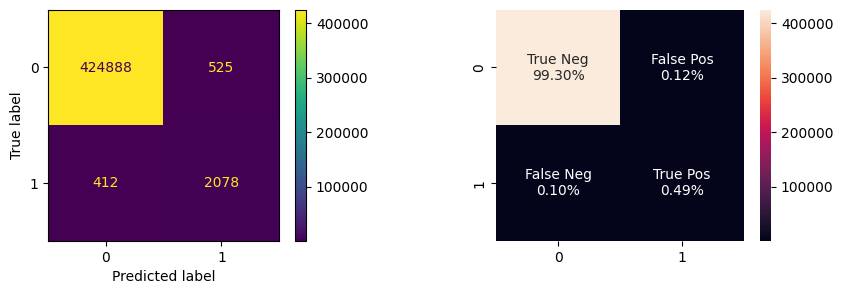

In [46]:
# Matrice di confusione
cmDT = confusion_matrix(y_validation, y_pred)

# Rappresentazione percentuale della confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cmDT.flatten()/np.sum(cmDT)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)

# Rappresentazione affiancata
sns.heatmap(cmDT, annot=labels, fmt='', ax=ax2)
ConfusionMatrixDisplay(confusion_matrix=cmDT).plot(ax=ax1);

---
#### 3.4.2. Random forest
Per random forest si intende un’aggregazione di alberi di decisione, costruita applicando la tecnica del bagging; il bagging, altrimenti noto come aggregazione bootstrap, permette ai singoli alberi decisionali di campionare casualmente dal dataset e sostituire i dati, creando risultati molto diversi nei singoli alberi. Questo significa che invece di includere tutti i dati disponibili, ogni albero prende solo alcuni dei dati. Questi alberi singoli prendono quindi decisioni basate sui dati a loro disposizione e prevedono i risultati basandosi solo su di essi. I dati di questi alberi vengono poi fusi insieme per assicurare le previsioni più accurate. Mentre un albero decisionale da solo dispone di un risultato e una gamma ristretta di gruppi, la foresta assicura un risultato più accurato con un numero maggiore di gruppi e decisioni. Ha l'ulteriore vantaggio di aggiungere casualità al modello trovando la caratteristica migliore tra un sottoinsieme casuale di caratteristiche. 

![Alt text](<0 YEwFetXQGPB8aDFV-1.png>)

In [47]:
# Allenamento del modello con Random Forest classifier

clfRFC = RandomForestClassifier()
clfRFC.fit(X_train, y_train)

RandomForestClassifier()

Valutazione del modello sul validation set

In [48]:
# Predizione dei valori 
y_pred = clfRFC.predict(X_validation)

# Calcolo delle metriche di valutazione
accuracyRF = accuracy_score(y_validation, y_pred)
precisionRF = precision_score(y_validation, y_pred)
recallRF = recall_score(y_validation, y_pred)
scoreRF = roc_auc_score(y_validation, y_pred)
f1RF = f1_score(y_validation, y_pred, average='macro')

print("Predizioni corrette (Accuracy): " + str(round(accuracyRF*100,2)) + "%") 
print("Probabilità che un positivo lo sia effettivamente (Precision): " + str(round(precisionRF*100,2)) + "%") 
print("Positivi effettivamente individuati (Recall):" + str(round(recallRF*100,2)) + "%") 
print(f"Capacità di distinzione fra le classi (ROC AUC score): {scoreRF:.4f}")
print(f"Performance (F1 score): {f1RF:.4f}")


Predizioni corrette (Accuracy): 99.85%
Probabilità che un positivo lo sia effettivamente (Precision): 97.41%
Positivi effettivamente individuati (Recall):76.91%
Capacità di distinzione fra le classi (ROC AUC score): 0.8845
Performance (F1 score): 0.9294


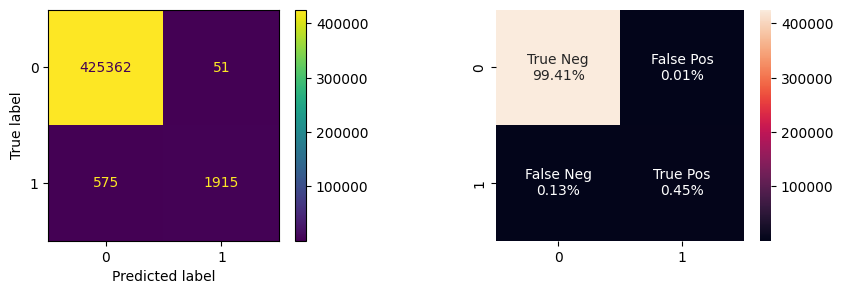

In [49]:
# Matrice di confusione
cmRF = confusion_matrix(y_validation, y_pred)

# Rappresentazione percentuale della confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cmRF.flatten()/np.sum(cmRF)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)

# Rappresentazione affiancata
sns.heatmap(cmRF, annot=labels, fmt='', ax=ax2)
ConfusionMatrixDisplay(confusion_matrix=cmRF).plot(ax=ax1);


---
#### 3.4.3. Isolation Forest
Isolation Forest è un algoritmo di machine learning utilizzato spesso per il rilevamento di anomalie in quanto permette di isolare ciascun punto del dataset sulla base della sua maggiore o minore distanza dagli altri punti. In altre parole, utilizza la media delle previsioni di diversi alberi decisionali quando assegna il punteggio finale di anomalia a un dato punto dati. A differenza di altri algoritmi di anomaly detection, che prima definiscono ciò che è "normale" e poi segnalano qualsiasi altra cosa come anomala, Isolation Forest tenta di isolare i punti dati anomali fin dall'inizio. 

Dati dei punti, l'algoritmo seleziona casualmente una dimensione e suddivide casualmente i dati lungo tale dimensione. I due sottospazi risultanti definiscono il proprio sottoalbero; il processo viene ripetuto finché ogni foglia dell'albero rappresenta un singolo punto dati del set di dati.

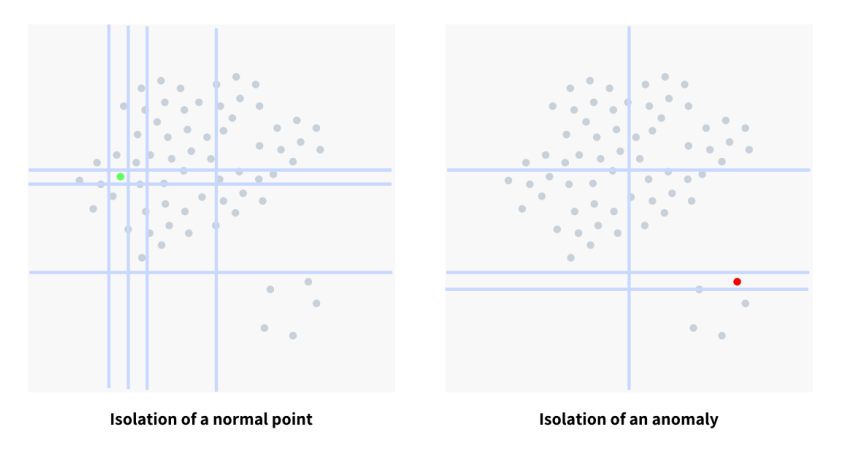

Fig. : L'isolamento di un punto valido e di un punto anomalo

In [50]:
# Allenamento del modello con Isolation Forest
clfIFC=IsolationForest()
clfIFC.fit(X_train)

IsolationForest()

Valutazione del modello sul validation set.
Algoritmi come Isolation Forest generano previsioni in valori binari utilizzando il valore -1. Prima di qualsiasi rappresentazione è dunque opportuno trasformare tali valori in 0.

In [51]:
# Predizione dei valori 
y_pred = clfIFC.predict(X_validation)

# Trasformazione delle predizioni
y_pred[y_pred == -1] = 0

# Calcolo delle metriche di valutazione
accuracyIF = accuracy_score(y_validation, y_pred)
precisionIF = precision_score(y_validation, y_pred)
recallIF = recall_score(y_validation, y_pred)
scoreIF = roc_auc_score(y_validation, y_pred)
f1IF = f1_score(y_validation, y_pred, average='macro')

print("Predizioni corrette (Accuracy): " + str(round(accuracyIF*100,2)) + "%") 
print("Probabilità che un positivo lo sia effettivamente (Precision): " + str(round(precisionIF*100,2)) + "%") 
print("Positivi effettivamente individuati (Recall):" + str(round(recallIF*100,2)) + "%") 
print(f"Capacità di distinzione fra le classi (ROC AUC score): {scoreIF:.4f}")
print(f"Performance (F1 score): {f1IF:.4f}")


Predizioni corrette (Accuracy): 23.97%
Probabilità che un positivo lo sia effettivamente (Precision): 0.16%
Positivi effettivamente individuati (Recall):20.96%
Capacità di distinzione fra le classi (ROC AUC score): 0.2248
Performance (F1 score): 0.1944


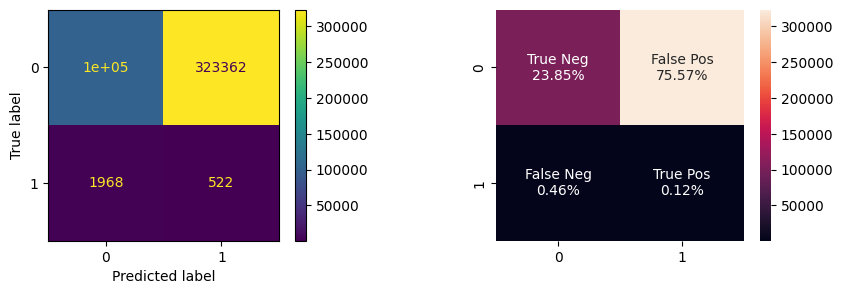

In [52]:
# Matrice di confusione
cmIF = confusion_matrix(y_validation, y_pred)

# Rappresentazione percentuale della confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cmIF.flatten()/np.sum(cmIF)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)

# Rappresentazione affiancata
sns.heatmap(cmIF, annot=labels, fmt='', ax=ax2)
ConfusionMatrixDisplay(confusion_matrix=cmIF).plot(ax=ax1);

Si evince come l'algoritmo vada in overfitting ovvero non sia in grado di individuare la reale natura dei casi in quanto apprende dei pattern specifici in maniera estremamente letterale per cui il modello perde di generalità e dunque comincia a individuare come positivi dei casi che in realtà non lo sono. 

Intervenendo sui parametri dell'algoritmo di isolation forest è possibile ottenere dei miglioramenti nelle prestazioni. In particolare, grazie al parametro "contamination" si riesce ad esprimere la percentuale, in un valore da 0 a 0.5, degli outliers rispetto al campione. Un valore estremamente alto sulla scala permette di rendere meno speciali i casi particolari e rendendoli più "normali" si può mitigare l'overfitting.

---
#### 3.4.4. Local Outlier Factor
Il Local outlier factor è un algoritmo che quantifica il punteggio di anomalia di un dato misurando la differenza di densità tra il dato stesso e i suoi vicini, analizzando dunque un’area locale piuttosto che globale. Il concetto di località è espresso attraverso il confronto con i suoi k-neighbor, ovvero i k valori più vicini al dato considerato. Più un punto risulta isolato dai suoi vicini, maggiore sarà il punteggio di anomalia che gli verrà attribuito.

![Alt text](Finding-Local-Outlier-Factor-LOF-for-probable-outliers-of-a-normal-cluster.png)

In [53]:
# Allenamento del modello con Local Outlier Factor
clfLOF = LocalOutlierFactor(n_neighbors=2)

Valutazione del modello sul validation set

In [54]:
# Predizione dei valori 
y_pred = clfLOF.fit_predict(X_validation)

# Trasformazione delle predizioni
y_pred[y_pred == -1] = 0

# Calcolo delle metriche di valutazione
accuracyLOF = accuracy_score(y_validation, y_pred)
precisionLOF = precision_score(y_validation, y_pred)
recallLOF= recall_score(y_validation, y_pred)
scoreLOF = roc_auc_score(y_validation, y_pred)
f1LOF = f1_score(y_validation, y_pred, average='macro')

print("Predizioni corrette (Accuracy): " + str(round(accuracyLOF*100,2)) + "%") 
print("Probabilità che un positivo lo sia effettivamente (Precision): " + str(round(precisionLOF*100,2)) + "%") 
print("Positivi effettivamente individuati (Recall): " + str(round(recallLOF*100,2)) + "%") 
print(f"Capacità di distinzione fra le classi (ROC AUC score): {scoreLOF:.4f}")
print(f"Performance (F1 score): {f1LOF:.4f}")

Predizioni corrette (Accuracy): 7.87%
Probabilità che un positivo lo sia effettivamente (Precision): 0.47%
Positivi effettivamente individuati (Recall): 74.66%
Capacità di distinzione fra le classi (ROC AUC score): 0.4107
Performance (F1 score): 0.0741


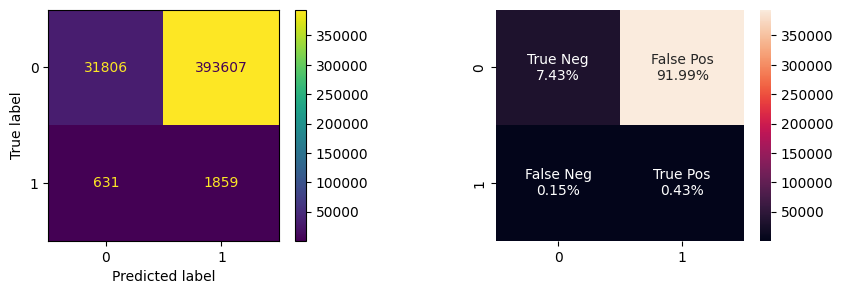

In [55]:
# Matrice di confusione
cmLOF = confusion_matrix(y_validation, y_pred)

# Rappresentazione percentuale della confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cmLOF.flatten()/np.sum(cmLOF)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)

# Rappresentazione affiancata
sns.heatmap(cmLOF, annot=labels, fmt='', ax=ax2)
ConfusionMatrixDisplay(confusion_matrix=cmLOF).plot(ax=ax1);

---
#### 3.4.5. DBSCAN

DBSCAN è un metodo di clustering utilizzato nell'apprendimento automatico per separare i cluster ad alta densità dai cluster a bassa densità, svolgendo un ottimo lavoro nel cercare aree nei dati che hanno un'alta densità di osservazioni, rispetto ad aree dei dati che non sono molto dense di osservazioni. Esso si basa su due parametri:
* Epsilon (ε): una misura di distanza che viene utilizzata per individuare i punti e per verificare la densità nelle vicinanze di qualsiasi punto.
* minPoints(n): il numero minimo di punti (dunque una soglia) raggruppati insieme affinché una regione sia considerata densa.

L'algoritmo funziona nel seguente modo:
1. Divide il set di dati in n dimensioni
2. Per ciascun punto nel set di dati, DBSCAN conta quanti punti dati si trovano all'interno della distanza ε (epsilon) da esso, considerando dunque questa forma come un cluster. Se la quantità di vicini è maggiore o uguale a minPoints (n), allora si considera il punto che si sta analizzando come punto centrale, per poi inserire tutti i vicini nello stesso cluster
3. Si espande in modo iterativo il cluster esaminando ogni singolo punto al suo interno e contando il numero di altri punti dati nelle vicinanze
4. Il procedimento continuerà ad espandere ciascun cluster finché non ci saranno più esempi da inserire.

 DBSCAN può essere dunque utilizzato per identificare outlier o punti di dati rumorosi nel dataset.

![Alt text](image-58-1.png)

In [56]:
# Allenamento del modello con DBSCAN
clfDBSCAN = DBSCAN()

Valutazione del modello sul validation set


In [57]:
# Predizione dei valori 
y_pred = clfDBSCAN.fit_predict(X_validation, y_validation)

# Trasformazione delle predizioni
y_pred[y_pred == -1] = 0

# Calcolo delle metriche di valutazione
accuracyDBSCAN = accuracy_score(y_validation, y_pred)
precisionDBSCAN = precision_score(y_validation, y_pred)
recallDBSCAN = recall_score(y_validation, y_pred)
scoreDBSCAN = roc_auc_score(y_validation, y_pred)
f1DBSCAN = f1_score(y_validation, y_pred, average='macro')

print("Predizioni corrette (Accuracy): " + str(round(accuracyDBSCAN*100,2)) + "%") 
print("Probabilità che un positivo lo sia effettivamente (Precision): " + str(round(precisionDBSCAN*100,2)) + "%") 
print("Positivi effettivamente individuati (Recall): " + str(round(recallDBSCAN*100,2)) + "%") 
print(f"Capacità di distinzione fra le classi (ROC AUC score): {scoreDBSCAN:.4f}")
print(f"Performance (F1 score): {f1DBSCAN:.4f}")


c:\Users\gaiab\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predizioni corrette (Accuracy): 99.42%
Probabilità che un positivo lo sia effettivamente (Precision): 0.0%
Positivi effettivamente individuati (Recall): 0.0%
Capacità di distinzione fra le classi (ROC AUC score): 0.5000
Performance (F1 score): 0.4985


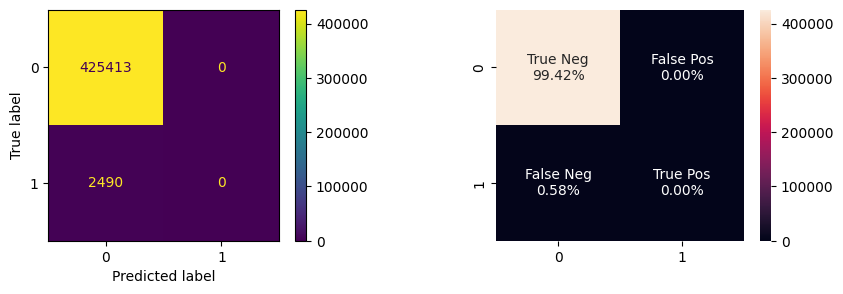

In [58]:
# Matrice di confusione
cmDBSCAN = confusion_matrix(y_validation, y_pred)

# Rappresentazione percentuale della confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cmDBSCAN.flatten()/np.sum(cmDBSCAN)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)

# Rappresentazione affiancata
sns.heatmap(cmDBSCAN, annot=labels, fmt='', ax=ax2)
ConfusionMatrixDisplay(confusion_matrix=cmDBSCAN).plot(ax=ax1);

#### 3.4.7. K Nearest Neighbors Classifier

L'algoritmo K Nearest Neighbors si basa sull'assunzione che oggetti similari esistono in prossimità fra di loro. In altre parole, l'idea di base è quella di fare previsioni basate sulla similarità tra l'istanza di test (punto di dati) e gli esempi di addestramento (punti di dati noti). Rilevante è la scelta del valore K, il quale rappresenta il numero di vicini più prossimi da considerare quando si effettua una previsione. Il valore di K deve essere scelto con attenzione e può influenzare le prestazioni dell'algoritmo.

L'algoritmo segue il seguente funzionamento:
1. Per ogni istanza di test, calcola la sua similarità (solitamente utilizzando la distanza euclidea, ma possono essere utilizzate altre metriche di distanza) con tutte le istanze di addestramento. Le istanze di addestramento più simili alla nuova istanza sono i "vicini" più prossimi.
2. Vengono contate quante istanze di addestramento in ciascuna classe si trovano tra i K vicini più prossimi. La nuova istanza viene quindi assegnata alla classe più comune tra i vicini. 

Il suo vantaggio è che non richiede una fase di addestramento elaborata, poiché memorizza semplicemente il set di addestramento. Tuttavia, l'algoritmo può essere computazionalmente costoso, specialmente quando il dataset è grande, poiché richiede il calcolo delle distanze tra la nuova istanza e tutte le istanze di addestramento.

In [59]:
clfKNNC = KNeighborsClassifier(n_neighbors=3)
clfKNNC.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

Valutazione del modello sul validation set

In [60]:
# Predizione dei valori 
y_pred = clfKNNC.predict(X_validation)

# Calcolo delle metriche di valutazione
accuracyKNN = accuracy_score(y_validation, y_pred)
precisionKNN = precision_score(y_validation, y_pred)
recallKNN = recall_score(y_validation, y_pred)
scoreKNN = roc_auc_score(y_validation, y_pred)
f1KNN = f1_score(y_validation, y_pred, average='macro')

print("Predizioni corrette (Accuracy): " + str(round(accuracyKNN*100,2)) + "%") 
print("Probabilità che un positivo lo sia effettivamente (Precision): " + str(round(precisionKNN*100,2)) + "%") 
print("Positivi effettivamente individuati (Recall): " + str(round(recallKNN*100,2)) + "%") 
print(f"Capacità di distinzione fra le classi (ROC AUC score): {scoreKNN:.4f}")
print(f"Performance (F1 score): {f1KNN:.4f}")


Predizioni corrette (Accuracy): 99.51%
Probabilità che un positivo lo sia effettivamente (Precision): 71.73%
Positivi effettivamente individuati (Recall): 26.91%
Capacità di distinzione fra le classi (ROC AUC score): 0.6342
Performance (F1 score): 0.6945


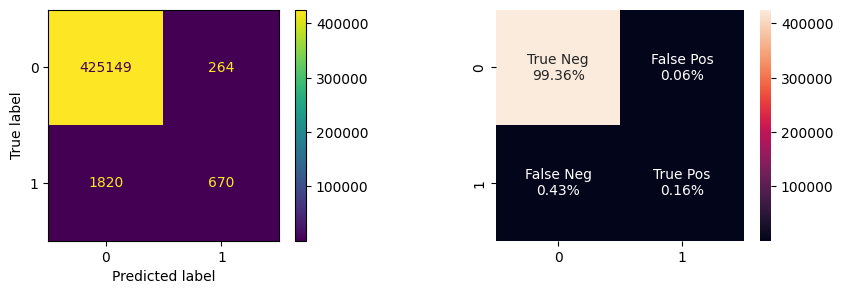

In [61]:
# Matrice di confusione
cmKNN = confusion_matrix(y_validation, y_pred)

# Rappresentazione percentuale della confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cmKNN.flatten()/np.sum(cmKNN)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)

# Rappresentazione affiancata
sns.heatmap(cmKNN, annot=labels, fmt='', ax=ax2)
ConfusionMatrixDisplay(confusion_matrix=cmKNN).plot(ax=ax1);


#### 3.5 Rappresentazione grafica degli score
Segue ora una rappresentazione grafica per la valutazione degli score dei modelli

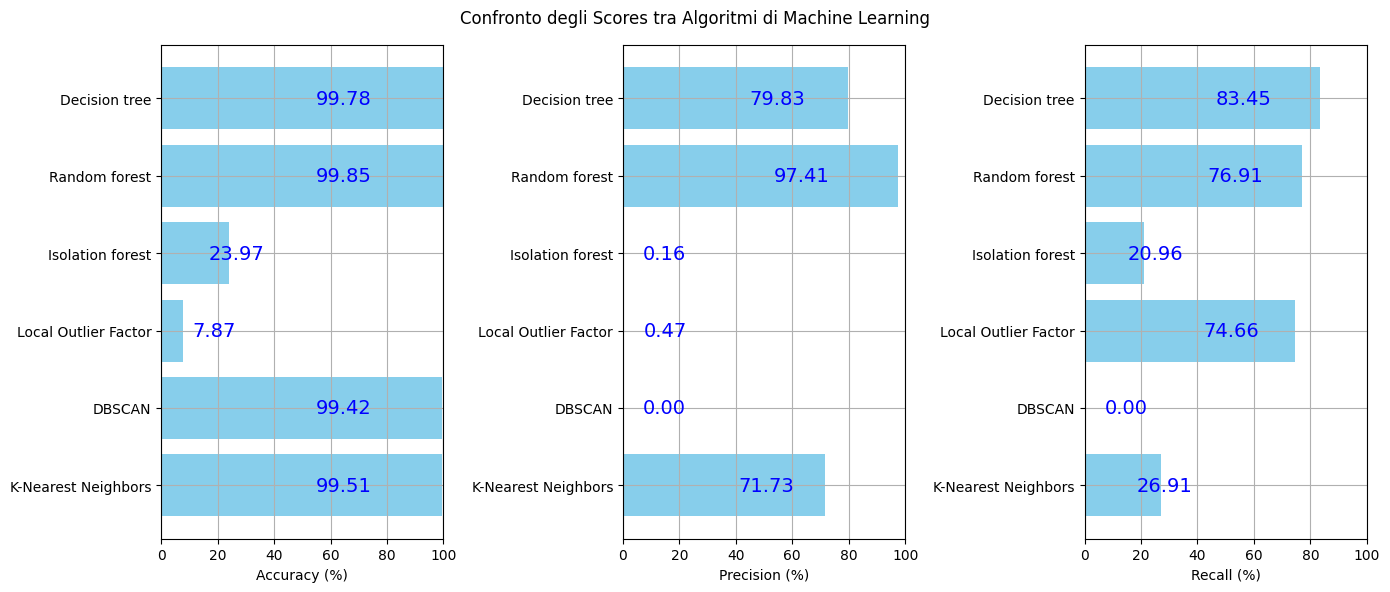

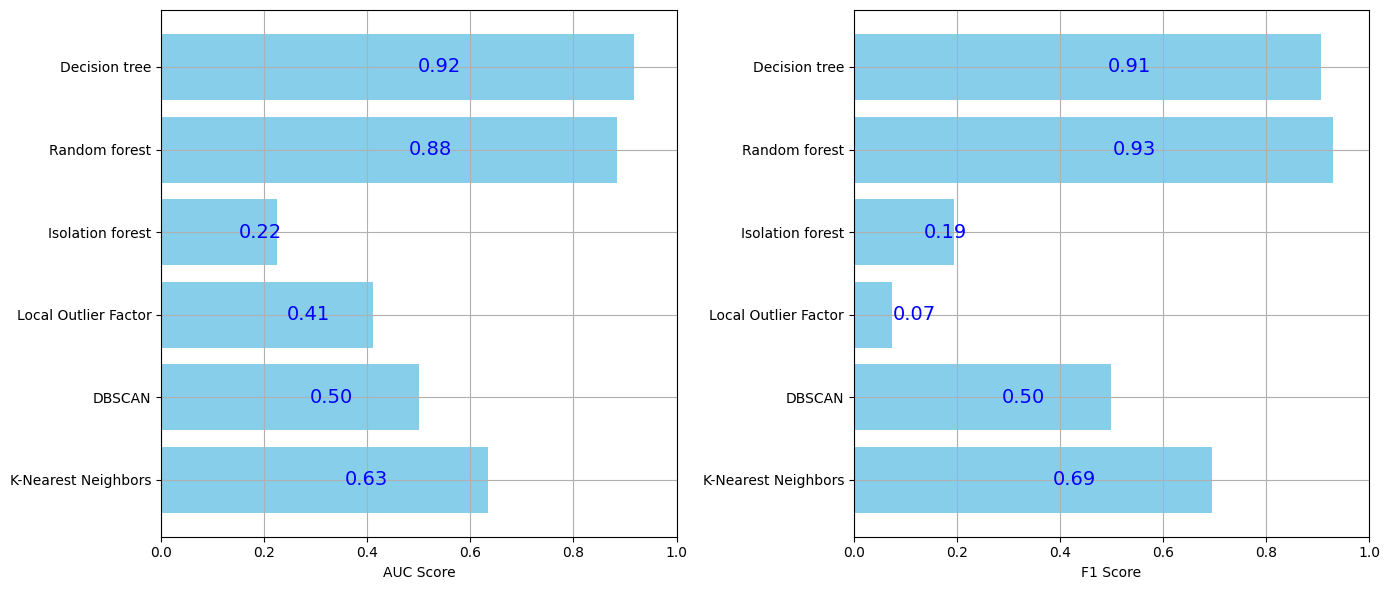

In [62]:
# Algoritmi utilizzati
algorithms = ['Decision tree', 'Random forest', 'Isolation forest','Local Outlier Factor', 'DBSCAN',
               'K-Nearest Neighbors']

# Lista degli scores corrispondenti agli algoritmi
accuracy_scores = [accuracyDT, accuracyRF, accuracyIF, accuracyLOF, accuracyDBSCAN, accuracyKNN]  
accuracy_scores = [x * 100 for x in accuracy_scores]
precision_scores = [precisionDT, precisionRF, precisionIF, precisionLOF, precisionDBSCAN, precisionKNN]
precision_scores = [x * 100 for x in precision_scores]
recall_scores = [recallDT, recallRF, recallIF,  recallLOF, recallDBSCAN, recallKNN]
recall_scores = [x * 100 for x in recall_scores]
auc_scores = [scoreDT, scoreRF, scoreIF, scoreLOF, scoreDBSCAN, scoreKNN]
f1_scores = [f1DT, f1RF, f1IF, f1LOF, f1DBSCAN, f1KNN]

# Plotting dei valori
fig1, axs1 = plt.subplots(1, 3, figsize=(14, 6))
fig1.suptitle('Confronto degli Scores tra Algoritmi di Machine Learning')

# Accuracy
a1 = axs1[0].barh(algorithms, accuracy_scores, color='skyblue')
axs1[0].set_xlabel('Accuracy (%)')
axs1[0].set_xlim(0, 100)
axs1[0].invert_yaxis()
axs1[0].bar_label(a1, labels=['%.2f' % e for e in accuracy_scores],
             padding=30, color='b', fontsize=14, label_type='center')

# Precision
a2 = axs1[1].barh(algorithms, precision_scores, color='skyblue')
axs1[1].set_xlabel('Precision (%)')
axs1[1].set_xlim(0, 100)
axs1[1].invert_yaxis()
axs1[1].bar_label(a2, labels=['%.2f' % e for e in precision_scores],
             padding=30, color='b', fontsize=14, label_type='center')


# Recall
a3 = axs1[2].barh(algorithms, recall_scores, color='skyblue')
axs1[2].set_xlabel('Recall (%)')
axs1[2].set_xlim(0, 100)
axs1[2].invert_yaxis()
axs1[2].bar_label(a3, labels=['%.2f' % e for e in recall_scores],
             padding=30, color='b', fontsize=14, label_type='center')

plt.tight_layout()
axs1[0].grid()
axs1[1].grid()
axs1[2].grid()

fig2, axs2 = plt.subplots(1, 2, figsize=(14, 6))

# AUC Scores
a4 = axs2[0].barh(algorithms, auc_scores, color='skyblue')
axs2[0].set_xlabel('AUC Score')
axs2[0].set_xlim(0, 1)
axs2[0].invert_yaxis()
axs2[0].bar_label(a4, labels=['%.2f' % e for e in auc_scores],
             padding=30, color='b', fontsize=14, label_type='center')


# F1 Score
a5 = axs2[1].barh(algorithms, f1_scores, color='skyblue')
axs2[1].set_xlabel('F1 Score')
axs2[1].set_xlim(0, 1)
axs2[1].invert_yaxis()
axs2[1].bar_label(a5, labels=['%.2f' % e for e in f1_scores],
             padding=30, color='b', fontsize=14, label_type='center')

plt.tight_layout()
axs2[0].grid()
axs2[1].grid()


### 3.6 Scelta del modello e tuning

La cattiva performance di alcuni modelli può essere spiegata con il fenomeno dell'overfitting. Infatti, la tendenza di alcuni modelli come Local Outlier Factor a vedere molti più positivi di quanti ce ne siano deriva spesso dalla loro giunta impossibilità di generalizzare a causa di una "memorizzazione" dei valori degli outlier. Ne consegue che anche con una operazione di SMOTE (ovvero di maggior rappresentazione degli outliers con lo scopo di renderli meno speciali e dunque più usuali) non si otterrebbe una differenza sostanziale in quanto essa non è altro che un'operazione di replicazione degli stessi. Altri algoritmi come DBSCAN, non sono invece in grado di individuare bene la distinzione fra le classi, facendo dunque ricadere tutti gli oggetti all'interno dei cluster definiti "normali". Si sottolinea, tuttavia, che ciascun algoritmo è stato richiamato con i suoi parametri di default, il che implica la necessità di introdurre dei ragionamenti sul tuning dei parametri, come di seguito affrontatp.

In base alle metriche utilizzate, dunque, l'algoritmo migliore è il Decision Tree. Tuttavia, lo stesso è stato utilizzato con i suoi parametri di default per cui le prestazioni possonno essere decisamente migliori tramite un settaggio ad hoc delle stesse. Per ottenere dei risultati ottimali senza dover ricorrere ad un tuning manuale (ovvero per tentativi) alla ricerca dei parametri ideali per inizializzare un modello di machine learning, si può eseguire l'auto tuning degli iper parametri di un modello attraverso algoritmi specifici.
La "Grid Search" è una delle tecniche di ottimizzazione dei parametri ed esamina un insieme predefinito di possibili combinazioni di parametri per poi valutare le prestazioni del modello su ciascuna combinazione attraverso la cross-validation. L'obiettivo è trovare la combinazione di parametri che produce le migliori prestazioni del modello in base a una metrica di valutazione specifica.
Esso funziona nel seguente modo:
1. Bisogna specificare una griglia di valori per i parametri del modello che desideri ottimizzare. 
2. La Grid Search eseguirà una ricerca esaustiva su tutte le possibili combinazioni dei parametri nella griglia definita. Per ciascuna combinazione, addestrerà il modello utilizzando quella configurazione e valuterà le prestazioni attraverso la cross-validation (solitamente con k-fold cross-validation).
3. Dopo aver esaminato tutte le combinazioni, la Grid Search restituirà il set di parametri che ha prodotto le migliori prestazioni in base alla metrica di valutazione specificata.
4. Con il set di parametri ottimizzato ottenuto dalla Grid Search, è possibile addestrare il modello finale.

Un altro algoritmo in grado di ricercare parametri migliori, è la Randomized search: mentre la Grid Search esamina tutte le possibili combinazioni di parametri da una griglia predefinita, la Randomized Search seleziona un sottoinsieme casuale di combinazioni da valutare, rendendola più efficiente in termini di tempo, specialmente quando si hanno molte combinazioni possibili.

Esso segue il seguente funzionamento:
1. Invece di definire una griglia predefinita di valori per ciascun parametro da ottimizzare, come nella Grid Search, nella Randomized Search si definiscono delle distribuzioni di probabilità per ciascun parametro. Queste distribuzioni possono essere uniformi, gaussiane o altre distribuzioni.
2. Seleziona casualmente un certo numero di combinazioni di parametri dalla distribuzione specificata per ciascun parametro. Questo è fatto utilizzando il campionamento casuale delle distribuzioni di probabilità. Il numero di combinazioni da valutare è specificato da un parametro chiamato n_iter.
3. Per ciascuna combinazione di parametri selezionata, viene addestrato un modello utilizzando quella configurazione e vengono valutate le prestazioni del modello attraverso la cross-validation (ad esempio, con k-fold cross-validation).
4. Alla fine delle valutazioni, la Randomized Search restituirà il set di parametri che ha prodotto le migliori prestazioni in base alla metrica di valutazione specificata.

La Randomized Search è più efficiente in termini di tempo perché non valuta tutte le combinazioni possibili di parametri e può scoprire buone combinazioni di parametri in modo più rapido rispetto alla Grid Search, poiché inizia a esplorare subito combinazioni casuali. Tuttavia, va notato che la Randomized Search potrebbe non essere in grado di trovare la combinazione "migliore assoluta" di parametri come farebbe la Grid Search se il budget computazionale lo permette.

Nel caso dell'algoritmo di Decision Tree, i parametri da tenere in considerazione sono i seguenti:
* Max_depth -> Questo argomento rappresenta la profondità massima di un albero. Se non specificato, l'albero viene espanso finché gli ultimi nodi foglia non contengono un singolo valore. Pertanto, riducendo questo contatore, possiamo impedire all'albero di apprendere tutti i campioni di addestramento, prevenendo così un adattamento eccessivo. Poiché non si è sicuri di quale profondità avrebbe il modello ideale, si può eseguire un ciclo for da un intervallo di numeri per scoprirlo. Osservando attentamente i risultati, si può trovare il max_depthvalore in cui l'accuratezza della convalida inizia a diminuire e l'accuratezza dell'addestramento inizia a crescere in modo eccessivo. 
* criterion -> Questo argomento va a definire il criterio aiutano a determinare quale variabile e quale suo valore dovrebbe essere utilizzato per suddividere un nodo in due o più sotto-nodi: il criterio Gini è una misura di quanto sia impura una divisione dei dati in un nodo e si calcola come la somma delle probabilità del quadrato di ciascuna classe sottratto da 1; un valore Gini più basso indica una maggiore purezza, cioè un nodo con dati che sono prevalentemente della stessa classe; il criterio di entropia è una misura dell'incertezza o della casualità nel nodo; un nodo con un'entropia più bassa indica una maggiore purezza e l'entropia si calcola come la somma delle probabilità delle classi moltiplicate per il loro logaritmo negativo.
* min_sample_leaf -> Questo parametro indica il numero minimo di campioni che devono essere presenti in una foglia dell'albero. In altre parole, stabilisce il limite inferiore sul numero di campioni che una foglia può contenere. Esso è importante perché può aiutare a evitare la creazione di suddivisioni eccessivamente dettagliate nell'albero che possono memorizzare il rumore nei dati di addestramento e comportare una scarsa capacità di generalizzazione su nuovi dati ovvero evita il fenomeno dell'overfitting.

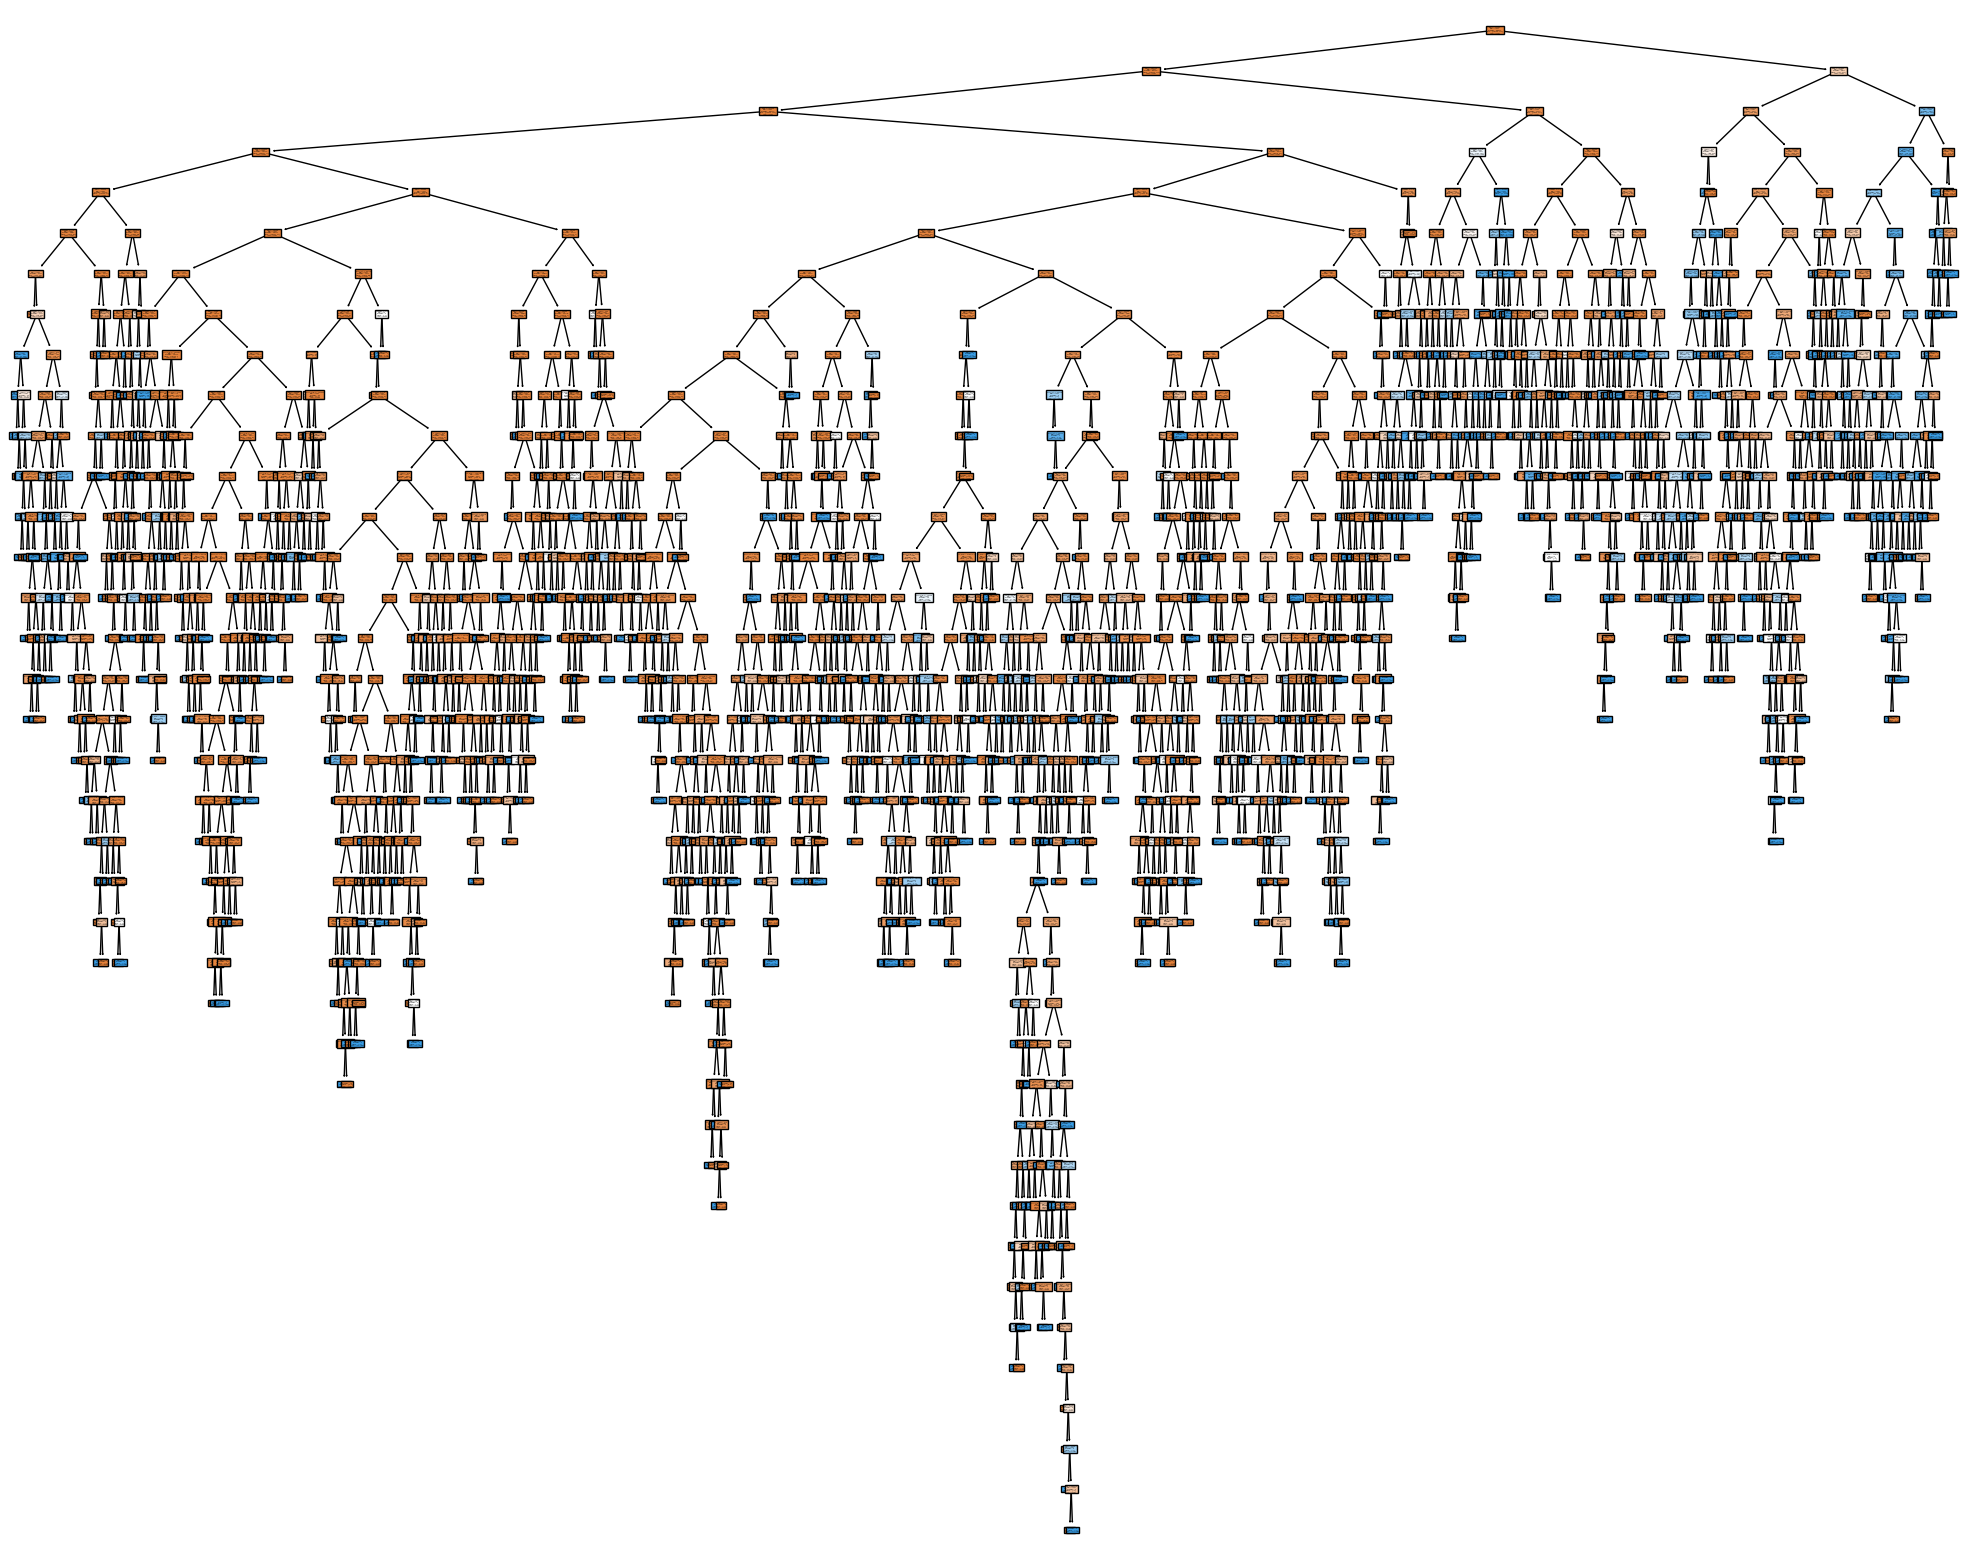

In [63]:
# Rappresentazione dell'albero di decisione
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clfDTC,
                   feature_names=list(dfMachine.columns),
                   class_names=['Frode', "Non frode"],
                   filled=True)

#### 3.6.1 Tuning su accuracy score

In [64]:
# Tuning sull'accuracy score
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_searchA = GridSearchCV(estimator=clfDTC, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

grid_searchA.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=30), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [65]:
grid_searchA.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10,
                       random_state=30)

In [66]:
# Modello con Decision Tree post tuning
dt_bestA = grid_searchA.best_estimator_

In [67]:
# Predizione dei valori 
y_pred = dt_bestA.predict(X_validation)

# Calcolo delle metriche di valutazione
accuracyDTT = accuracy_score(y_validation, y_pred)
precisionDTT = precision_score(y_validation, y_pred)
recallDTT = recall_score(y_validation, y_pred)
scoreDTT = roc_auc_score(y_validation, y_pred)
f1DTT = f1_score(y_validation, y_pred, average='macro')

print("Predizioni corrette (Accuracy): " + str(round(accuracyDTT*100,2)) + "%") 
print("Probabilità che un positivo lo sia effettivamente (Precision): " + str(round(precisionDTT*100,2)) + "%") 
print("Positivi effettivamente individuati (Recall):" + str(round(recallDTT*100,2)) + "%") 
print(f"Capacità di distinzione fra le classi (ROC AUC score): {scoreDTT:.4f}")
print(f"Performance (F1 score): {f1DTT:.4f}")

Predizioni corrette (Accuracy): 99.86%
Probabilità che un positivo lo sia effettivamente (Precision): 92.91%
Positivi effettivamente individuati (Recall):82.05%
Capacità di distinzione fra le classi (ROC AUC score): 0.9101
Performance (F1 score): 0.9353


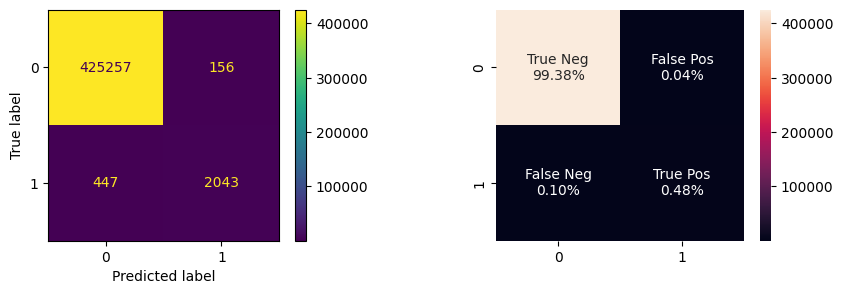

In [68]:
# Matrice di confusione
cmDTT = confusion_matrix(y_validation, y_pred)

# Rappresentazione percentuale della confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cmDTT.flatten()/np.sum(cmDTT)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)

# Rappresentazione affiancata
sns.heatmap(cmDTT, annot=labels, fmt='', ax=ax2)
ConfusionMatrixDisplay(confusion_matrix=cmDTT).plot(ax=ax1);

#### 3.6.2 Tuning su recall score

In [69]:
# Tuning sulla recall score
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_searchR = GridSearchCV(estimator=clfDTC, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "recall")

grid_searchR.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=30), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='recall', verbose=1)

In [70]:
grid_searchR.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,
                       random_state=30)

In [71]:
# Modello con Decision Tree post tuning
dt_bestR = grid_searchR.best_estimator_

In [72]:
# Predizione dei valori 
y_pred = dt_bestR.predict(X_validation)

# Calcolo delle metriche di valutazione
accuracyDTT = accuracy_score(y_validation, y_pred)
precisionDTT = precision_score(y_validation, y_pred)
recallDTT = recall_score(y_validation, y_pred)
scoreDTT = roc_auc_score(y_validation, y_pred)
f1DTT = f1_score(y_validation, y_pred, average='macro')

print("Predizioni corrette (Accuracy): " + str(round(accuracyDTT*100,2)) + "%") 
print("Probabilità che un positivo lo sia effettivamente (Precision): " + str(round(precisionDTT*100,2)) + "%") 
print("Positivi effettivamente individuati (Recall):" + str(round(recallDTT*100,2)) + "%") 
print(f"Capacità di distinzione fra le classi (ROC AUC score): {scoreDTT:.4f}")
print(f"Performance (F1 score): {f1DTT:.4f}")

Predizioni corrette (Accuracy): 99.84%
Probabilità che un positivo lo sia effettivamente (Precision): 86.95%
Positivi effettivamente individuati (Recall):84.54%
Capacità di distinzione fra le classi (ROC AUC score): 0.9223
Performance (F1 score): 0.9282


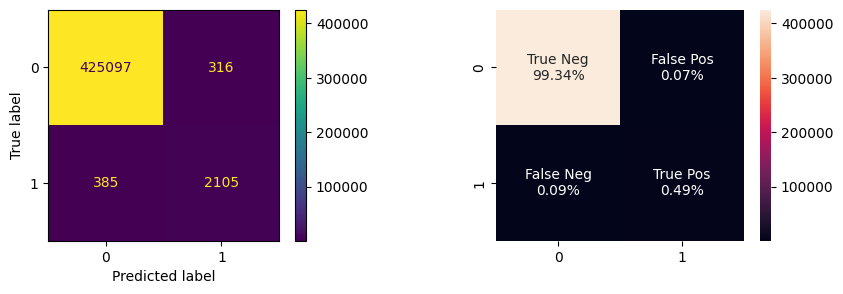

In [73]:
# Matrice di confusione
cmDTT = confusion_matrix(y_validation, y_pred)

# Rappresentazione percentuale della confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cmDTT.flatten()/np.sum(cmDTT)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)

# Rappresentazione affiancata
sns.heatmap(cmDTT, annot=labels, fmt='', ax=ax2)
ConfusionMatrixDisplay(confusion_matrix=cmDTT).plot(ax=ax1);


#### 3.6.3 Tuning su f1 score

In [74]:
# Tuning sull'f1 score
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_searchF = GridSearchCV(estimator=clfDTC, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "f1")

grid_searchF.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=30), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='f1', verbose=1)

In [75]:
grid_searchF.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10,
                       random_state=30)

In [76]:
# Modello con Decision Tree post tuning
dt_best = grid_searchF.best_estimator_

In [77]:
# Predizione dei valori 
y_pred = dt_best.predict(X_validation)

# Calcolo delle metriche di valutazione
accuracyDTT = accuracy_score(y_validation, y_pred)
precisionDTT = precision_score(y_validation, y_pred)
recallDTT = recall_score(y_validation, y_pred)
scoreDTT = roc_auc_score(y_validation, y_pred)
f1DTT = f1_score(y_validation, y_pred, average='macro')

print("Predizioni corrette (Accuracy): " + str(round(accuracyDTT*100,2)) + "%") 
print("Probabilità che un positivo lo sia effettivamente (Precision): " + str(round(precisionDTT*100,2)) + "%") 
print("Positivi effettivamente individuati (Recall):" + str(round(recallDTT*100,2)) + "%") 
print(f"Capacità di distinzione fra le classi (ROC AUC score): {scoreDTT:.4f}")
print(f"Performance (F1 score): {f1DTT:.4f}")

Predizioni corrette (Accuracy): 99.86%
Probabilità che un positivo lo sia effettivamente (Precision): 92.91%
Positivi effettivamente individuati (Recall):82.05%
Capacità di distinzione fra le classi (ROC AUC score): 0.9101
Performance (F1 score): 0.9353


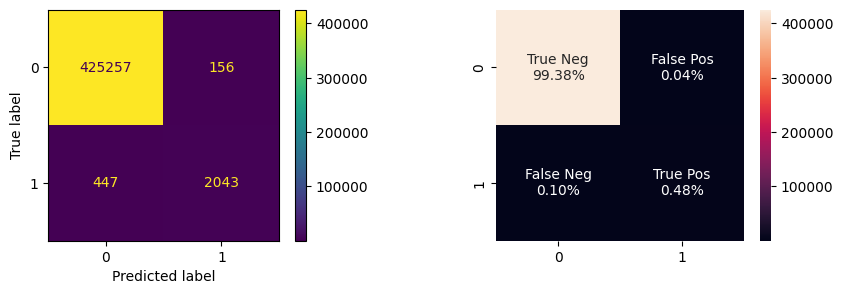

In [78]:
# Matrice di confusione
cmDTT = confusion_matrix(y_validation, y_pred)

# Rappresentazione percentuale della confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cmDTT.flatten()/np.sum(cmDTT)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)

# Rappresentazione affiancata
sns.heatmap(cmDTT, annot=labels, fmt='', ax=ax2)
ConfusionMatrixDisplay(confusion_matrix=cmDTT).plot(ax=ax1);


Fra i vari tuning effettuati, per le circostanze in esame il modello migliore è quello ottenuto con tuning sul recall score. Infatti, il recall score misura la quantità di positivi effettivamente effettuati; in un problema di anomaly detection come la ricerca di transazioni fraudolente è molto più rilevante individuare delle transazioni corrette come fraudolente piuttosto che il contrario per cui ciò che si ricerca è una maggiore capacità di individuazione di positivi. Inoltre, rispetto al modello con i parametri di default è stato in grado di individuare meno falsi positivi.

---
#### 3.7 Applicazione sul test set

Una volta scelto il modello, lo si applica alla parte di dataset estrapolata per le operazioni di testing.

In [79]:
dfTest['age'] = dfTest['dob'].apply(age)
dfTest['trans_date_trans_time'] = pd.to_datetime(dfTest['trans_date_trans_time'])
dfTest['date'] = dfTest['trans_date_trans_time'].dt.strftime("%Y-%m-%d")
dfTest['time'] = dfTest['trans_date_trans_time'].dt.strftime("%H:%M:%S")

In [80]:
dfTest

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,date,time
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,55,2020-06-21,12:14:25
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,33,2020-06-21,12:14:33
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,52,2020-06-21,12:14:53
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,36,2020-06-21,12:15:15
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,68,2020-06-21,12:15:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,57,2020-12-31,23:59:07
555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,23,2020-12-31,23:59:09
555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,41,2020-12-31,23:59:15
555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,...,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,57,2020-12-31,23:59:24


In [81]:
dfTest = dfTest.drop(['trans_date_trans_time', 'merchant',
              'first', 'zip', 'dob', 'unix_time',
              'street', 'cc_num', 'lat', 'long'], axis=1)


In [82]:
# One-hot encoding

label_encoder = preprocessing.LabelEncoder()

columnsToLabel = ['category', 'city', 'date', 'time', 'gender', 'state', 'job', 'last']

for col in columnsToLabel:
    dfTest[col] = label_encoder.fit_transform(dfTest[col].astype(str))

dfTest = dfTest.drop(columns=['trans_num'])

X_test = dfTest.drop('is_fraud', axis=1)
y_test = dfTest['is_fraud']


In [83]:
# Modello con stima migliore
dt_bestR = grid_searchR.best_estimator_

# Predizione dei valori 
y_pred = dt_bestR.predict(X_test)

# Calcolo delle metriche di valutazione
accuracyDTT = accuracy_score(y_test, y_pred)
precisionDTT = precision_score(y_test, y_pred)
recallDTT = recall_score(y_test, y_pred)
scoreDTT = roc_auc_score(y_test, y_pred)
f1DTT = f1_score(y_test, y_pred, average='macro')

print("Predizioni corrette (Accuracy): " + str(round(accuracyDTT*100,2)) + "%") 
print("Probabilità che un positivo lo sia effettivamente (Precision): " + str(round(precisionDTT*100,2)) + "%") 
print("Positivi effettivamente individuati (Recall):" + str(round(recallDTT*100,2)) + "%") 
print(f"Capacità di distinzione fra le classi (ROC AUC score): {scoreDTT:.4f}")
print(f"Performance (F1 score): {f1DTT:.4f}")

Predizioni corrette (Accuracy): 99.84%
Probabilità che un positivo lo sia effettivamente (Precision): 78.43%
Positivi effettivamente individuati (Recall):79.86%
Capacità di distinzione fra le classi (ROC AUC score): 0.8989
Performance (F1 score): 0.8953


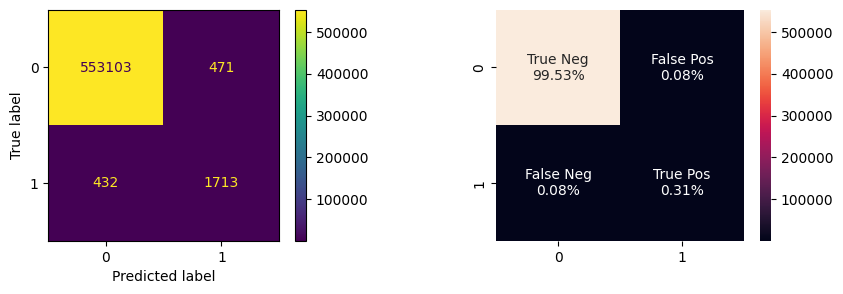

In [84]:
# Matrice di confusione
cmDTT = confusion_matrix(y_test, y_pred)

# Rappresentazione percentuale della confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cmDTT.flatten()/np.sum(cmDTT)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)

# Rappresentazione affiancata
sns.heatmap(cmDTT, annot=labels, fmt='', ax=ax2)
ConfusionMatrixDisplay(confusion_matrix=cmDTT).plot(ax=ax1);


---
## 4. Conclusioni

Comparando i modelli e i relativi risultati, il modello migliore è stato scelto soprattutto in base al valore di recall. Tale score, infatti, esprime quanti positivi sul totale si è riusciti ad individuare, fornendo dunque una misura interessante per i casi di anomaly detection come quello affrontato in questo progetto. A tal proposito è stato dunque scelto l'algoritmo Decision Tree al quale è stato poi applicato un meccanismo di tuning automatico in modo da individuare dei valori per i suoi parametri in modo da migliorare le prestazioni e dunque le sue metriche di valutazione. A seguito di questa azione, il modello ottenuto è in grado di individuare pochi falsi positivi e pochi falsi negativi ma una buona quantità di effettivamente positivi, facendo infatti passare la recall da un valore pari all'83.01% a 84.94%. Inoltre, le predizioni corrette superano il 99%, comportando quindi una buona performance generale.